# Setup Inicial

Instalar o wget caso não possua no seu computador, ou baixar o dataset direto pelo link abaixo

In [ ]:
!wget -q --show-progress http://cin.ufpe.br/~llm2/newAnime.zip -O newAnime.zip
!unzip -o newAnime.zip

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from scipy import stats

# Load dos dados


Os dados foram coletados utilizando a API Jikan que acessa o site MyAnimeList

Foi feito a iteração pelos id's disponiveis nesse [dataset](https://www.kaggle.com/marlesson/myanimelist-dataset-animes-profiles-reviews), realizado na data 24/9.

Script disponivel [aqui](https://github.com/lionliu/trending-mal/blob/master/scraping/get_updated_data.py)

In [2]:
animeList = pd.read_csv("./newAnime.csv")
animeList = animeList.drop_duplicates(subset = ['title'])

In [3]:
len(animeList)

16152

# Pre-processamento

In [4]:
animeList.head()

,mal_id,title,studios,genres,source,rank,score,popularity,members,favorites,episodes
0,28891,Haikyuu!! Second Season,['Production I.G'],"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",Manga,28.0,8.78,107,697848,12042,25.0
1,23273,Shigatsu wa Kimi no Uso,['A-1 Pictures'],"['Drama', 'Music', 'Romance', 'School', 'Shoun...",Manga,30.0,8.78,24,1243086,62708,22.0
2,34599,Made in Abyss,['Kinema Citrus'],"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",Web manga,31.0,8.77,90,749670,26738,13.0
3,5114,Fullmetal Alchemist: Brotherhood,['Bones'],"['Action', 'Military', 'Adventure', 'Comedy', ...",Manga,1.0,9.22,4,1958597,163518,64.0
4,31758,Kizumonogatari III: Reiketsu-hen,['Shaft'],"['Action', 'Mystery', 'Supernatural', 'Vampire']",Light novel,23.0,8.82,448,273788,4078,1.0


In [5]:
animeList.describe()

,mal_id,rank,score,popularity,members,favorites,episodes
count,16152.000000,14644.000000,11678.000000,16152.000000,1.615200e+04,16152.000000,15857.000000
mean,19839.860451,7553.685059,6.531732,8339.620542,3.298030e+04,432.011949,11.743772
std,14198.966601,4419.928194,0.884172,4867.903882,1.137269e+05,3707.060359,48.893022
min,1.000000,1.000000,1.860000,1.000000,3.900000e+01,0.000000,1.000000
25%,5288.750000,3728.000000,5.950000,4112.750000,3.550000e+02,0.000000,1.000000
50%,19816.000000,7501.500000,6.540000,8291.500000,2.194500e+03,3.000000,2.000000
75%,34050.250000,11314.000000,7.160000,12559.250000,1.364050e+04,31.000000,12.000000
max,40960.000000,15424.000000,9.220000,17019.000000,2.248940e+06,163518.000000,3057.000000


In [6]:
animeList.dtypes

mal_id          int64
title          object
studios        object
genres         object
source         object
rank          float64
score         float64
popularity      int64
members         int64
favorites       int64
episodes      float64
dtype: object

In [7]:
animeList.corr()

,mal_id,rank,score,popularity,members,favorites,episodes
mal_id,1.000000,0.373640,-0.080844,0.338287,-0.043458,-0.043048,-0.073674
rank,0.373640,1.000000,-0.973429,0.866531,-0.380724,-0.186544,-0.028117
score,-0.080844,-0.973429,1.000000,-0.707403,0.416330,0.248710,0.095151
popularity,0.338287,0.866531,-0.707403,1.000000,-0.431496,-0.190086,-0.023603
members,-0.043458,-0.380724,0.416330,-0.431496,1.000000,0.777209,0.052586
favorites,-0.043048,-0.186544,0.248710,-0.190086,0.777209,1.000000,0.063877
episodes,-0.073674,-0.028117,0.095151,-0.023603,0.052586,0.063877,1.000000


Remoção das seguintes colunas:


*   mal_id: ID do anime, que não agregaria a analise de dados
*   rank: ordenamento por score dos animes
*   popularity: ordenamento por quantidade de membros



In [8]:
animeList = animeList.drop(['mal_id', 'rank', 'popularity'], axis=1)

In [9]:
# animeList[(animeList['genres'] == '[]') & (animeList['studios'] == '[]')]
# 0,03% dos dados, e também, pode não conter source, nem score, e nem rank, e alguns sequer episodios, com rápida pesquisa, aparentam ser curta metragens
print(len(animeList[(animeList['genres'] == '[]') & (animeList['studios'] == '[]')])/len(animeList))
animeList = animeList[(animeList['genres'] != '[]') | (animeList['studios'] != '[]')]

0.003033680039623576


In [10]:
animeList = animeList.replace({'genres':'[]','studios':'[]'},"['Unknown']")

In [11]:
# Criar uma coluna a partir da coluna de generos de string para lista
def string_to_list(s):
    return s.strip('][').split(', ')
  
def remove_quotes(s):
    return list(map(lambda a: a.strip('\''), s))

genreList = animeList['genres'].apply(string_to_list).apply(remove_quotes)
studioList = animeList['studios'].apply(string_to_list).apply(remove_quotes)
animeList['studiosList'] = animeList['studios'].apply(string_to_list).apply(remove_quotes)
animeList['genresList'] = animeList['genres'].apply(string_to_list).apply(remove_quotes)

In [12]:
import itertools
# Gerar uma lista de todos os generos de animes
genreListArr = sorted(set(itertools.chain.from_iterable(genreList)))
studioListArr = sorted(set(itertools.chain.from_iterable(studioList)))
print(genreListArr)
# print(studioListArr)
print("\nQuantidade de gêneros : " + str(len(genreListArr)) + "\nQuantidade de estúdios: " + str(len(studioListArr)))

['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai', 'Historical', 'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody', 'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai', 'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural', 'Thriller', 'Unknown', 'Vampire', 'Yaoi', 'Yuri']

Quantidade de gêneros : 44
Quantidade de estúdios: 643


In [13]:
# Relação de nulos sobre o total
print(animeList.isna().sum() / len(animeList))
print(animeList.isna().sum())

title          0.000000
studios        0.000000
genres         0.000000
source         0.000000
score          0.275601
members        0.000000
favorites      0.000000
episodes       0.018195
studiosList    0.000000
genresList     0.000000
dtype: float64
title             0
studios           0
genres            0
source            0
score          4438
members           0
favorites         0
episodes        293
studiosList       0
genresList        0
dtype: int64


Mesmo que os scores faltantes tenham uma proporção consideravel de 27%, decidimos tirar pois já temos uma quantidade consideravel de dados, e também é provavél que os animes com scores faltando serem os mais desconhecidos, logo não seriam interessantes para a nossa análise.

In [14]:
animeList = animeList[animeList['score'].notnull()]

In [15]:
animeList = animeList[animeList['episodes'].notnull()]

Vamos cortar os animes por 6 quantis de membros, para assim podermos atribuir uma categoria a cada quartil com um rank e fazer uma análise mais na frente.

In [16]:
animeList['categoryByMembers'] = pd.qcut(animeList['members'], 6)
animeList['categoryByMembers'] = animeList['categoryByMembers'].astype('category')
animeList['categoryByMembers'].value_counts()

(184.999, 933.0]          1932
(55848.333, 2248940.0]    1931
(14896.667, 55848.333]    1931
(933.0, 2353.0]           1931
(5306.0, 14896.667]       1930
(2353.0, 5306.0]          1930
Name: categoryByMembers, dtype: int64

In [17]:
animeList['categoryByMembers'].cat.categories = ['Iron', 'Bronze', 'Silver', 'Gold','Platinum', 'Diamond']
animeList['categoryByMembers'].value_counts()

Iron        1932
Diamond     1931
Platinum    1931
Bronze      1931
Gold        1930
Silver      1930
Name: categoryByMembers, dtype: int64

Fazer uma coluna apenas com o primeiro estúdio da lista  para poder definir-la como categoria.

In [18]:
len(animeList[animeList.studiosList.str.len() > 1])

616

In [19]:
animeList['studio'] = animeList.studiosList.apply(lambda x: x[0])
animeList['studio'] = animeList.studio.astype('category')
animeList['studioCode'] = animeList.studio.cat.codes

In [20]:
animeList['studioCode']

0        302
1          6
2        202
3         67
4        334
        ... 
18929    399
18930      5
18931    110
18932    471
18933    206
Name: studioCode, Length: 11585, dtype: int16

### Remoção de outliers e normalização

#### Univariada

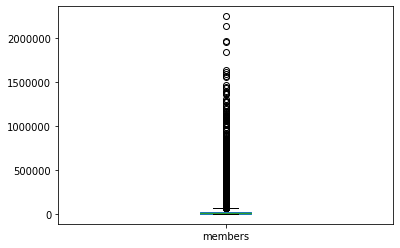

In [21]:
# Necessidade de retirar outliers
animeList['members'].plot.box()

0.6955794922225345


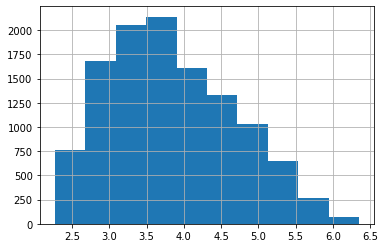

In [22]:
animeList['members_log'] = np.log10(animeList['members'])
print(animeList['members_log'].mad())
animeList['members_log'].hist()

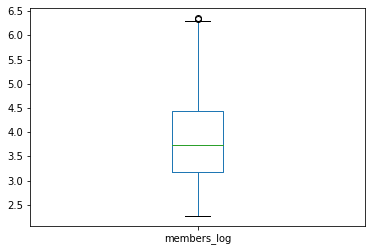

In [23]:
animeList['members_log'].plot.box()

Os outliers pelo método Z-score robusto com um limiar de 3 são os animes mais famosos, logo sua quantidade de membros é normal para a sua popularidade, não havendo a necessidade de remove-los

In [24]:
animeList[abs(animeList['members_log']-animeList['members_log'].median()) / animeList['members_log'].mad() > 3]

,title,studios,genres,source,score,members,favorites,episodes,studiosList,genresList,categoryByMembers,studio,studioCode,members_log
0,Haikyuu!! Second Season,['Production I.G'],"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",Manga,8.78,697848,12042,25.0,[Production I.G],"[Comedy, Sports, Drama, School, Shounen]",Diamond,Production I.G,302,5.843761
1,Shigatsu wa Kimi no Uso,['A-1 Pictures'],"['Drama', 'Music', 'Romance', 'School', 'Shoun...",Manga,8.78,1243086,62708,22.0,[A-1 Pictures],"[Drama, Music, Romance, School, Shounen]",Diamond,A-1 Pictures,6,6.094501
2,Made in Abyss,['Kinema Citrus'],"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",Web manga,8.77,749670,26738,13.0,[Kinema Citrus],"[Sci-Fi, Adventure, Mystery, Drama, Fantasy]",Diamond,Kinema Citrus,202,5.874870
3,Fullmetal Alchemist: Brotherhood,['Bones'],"['Action', 'Military', 'Adventure', 'Comedy', ...",Manga,9.22,1958597,163518,64.0,[Bones],"[Action, Military, Adventure, Comedy, Drama, M...",Diamond,Bones,67,6.291945
5,Mob Psycho 100 II,['Bones'],"['Action', 'Slice of Life', 'Comedy', 'Superna...",Web manga,8.86,674704,16763,13.0,[Bones],"[Action, Slice of Life, Comedy, Supernatural]",Diamond,Bones,67,5.829113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17535,Tokyo Ghoul √A,['Studio Pierrot'],"['Action', 'Mystery', 'Horror', 'Psychological...",Manga,7.11,1081949,9998,12.0,[Studio Pierrot],"[Action, Mystery, Horror, Psychological, Super...",Diamond,Studio Pierrot,399,6.034207
17718,Highschool of the Dead,['Madhouse'],"['Action', 'Horror', 'Supernatural', 'Ecchi', ...",Manga,7.18,1029540,9297,12.0,[Madhouse],"[Action, Horror, Supernatural, Ecchi, Shounen]",Diamond,Madhouse,224,6.012643
17815,Black Bullet,"['Kinema Citrus', 'Orange']","['Action', 'Sci-Fi', 'Mystery', 'Seinen']",Light novel,7.21,656348,3507,13.0,"[Kinema Citrus, Orange]","[Action, Sci-Fi, Mystery, Seinen]",Diamond,Kinema Citrus,202,5.817134
18494,Date A Live,['AIC Plus+'],"['Sci-Fi', 'Harem', 'Comedy', 'Romance', 'Mech...",Light novel,7.26,649085,10657,12.0,[AIC Plus+],"[Sci-Fi, Harem, Comedy, Romance, Mecha, School]",Diamond,AIC Plus+,15,5.812302


In [25]:
q1 = animeList['members_log'].quantile(q=0.25)
q3 = animeList['members_log'].quantile(q=0.75)
# Intervalo interquartil
iqr = q3 - q1
print(iqr)

1.2481147376948836


Há 2 outliers pelo método de Tukey, mas não iremos remove-los pelo mesmo motivo acima

In [26]:
print(len(animeList[animeList['members_log'] < (q1-1.5*iqr)]))
print(len(animeList[animeList['members_log'] > (q3+1.5*iqr)]))

0
2


In [27]:
animeList[animeList['members_log'] > (q3+1.5*iqr)]

,title,studios,genres,source,score,members,favorites,episodes,studiosList,genresList,categoryByMembers,studio,studioCode,members_log
678,Shingeki no Kyojin,['Wit Studio'],"['Action', 'Military', 'Mystery', 'Super Power...",Manga,8.45,2138732,101212,25.0,[Wit Studio],"[Action, Military, Mystery, Super Power, Drama...",Diamond,Wit Studio,482,6.330156
737,Death Note,['Madhouse'],"['Mystery', 'Police', 'Psychological', 'Supern...",Manga,8.62,2248940,126576,37.0,[Madhouse],"[Mystery, Police, Psychological, Supernatural,...",Diamond,Madhouse,224,6.351978


#### Bivariada

Gerar uma nova coluna com a razão de favoritos por membros, pois todos que favoritaram são membros, mas nem todos os membros favoritaram.

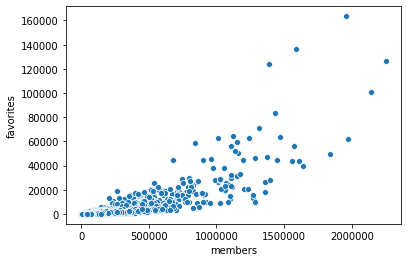

In [28]:
# animeList.plot.scatter('members', 'favorites')
sns.scatterplot(x=animeList['members'], y=animeList['favorites'])

In [29]:
animeList['favorite_per_member'] = animeList['favorites'] / animeList['members']

In [30]:
animeList['favorite_per_member'].describe()

count    11585.000000
mean         0.003419
std          0.005361
min          0.000000
25%          0.000727
50%          0.001848
75%          0.003967
max          0.089721
Name: favorite_per_member, dtype: float64

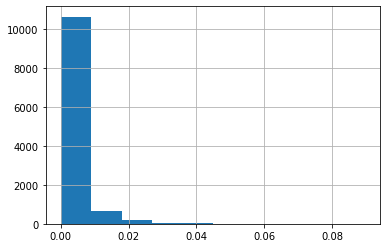

In [31]:
animeList['favorite_per_member'].hist()

In [32]:
animeList['favorite_per_member'] = np.log10(animeList['favorite_per_member'])

/Users/lionliu/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


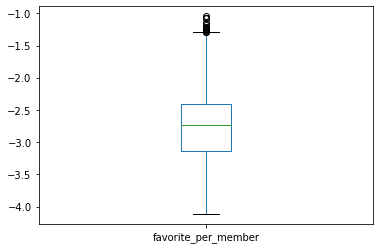

In [33]:
animeList['favorite_per_member'].plot.box()

Não há outliers pelo z-score robusto

In [34]:
animeList[abs(animeList['favorite_per_member']-animeList['favorite_per_member'].median())/animeList['favorite_per_member'].mad() > 3]

,title,studios,genres,source,score,members,favorites,episodes,studiosList,genresList,categoryByMembers,studio,studioCode,members_log,favorite_per_member


In [35]:
q1 = animeList['favorite_per_member'].quantile(q=0.25)
q3 = animeList['favorite_per_member'].quantile(q=0.75)
# Intervalo interquartil
iqr = q3 - q1
print(iqr)

0.7371642429042691


In [36]:
animeList[animeList['favorite_per_member'] < (q1-1.5*iqr)]

,title,studios,genres,source,score,members,favorites,episodes,studiosList,genresList,categoryByMembers,studio,studioCode,members_log,favorite_per_member
1094,Hentatsu,['Unknown'],['Comedy'],Original,5.56,1215,0,9.0,[Unknown],[Comedy],Bronze,Unknown,471,3.084576,-inf
1099,Uchuu no Kishi Tekkaman Blade OVA: Missing Link,['Unknown'],"['Action', 'Mecha', 'Sci-Fi', 'Shounen']",Unknown,6.04,1622,0,1.0,[Unknown],"[Action, Mecha, Sci-Fi, Shounen]",Bronze,Unknown,471,3.210051,-inf
1100,Ultraman Kids no Kotowaza Monogatari,['Unknown'],"['Comedy', 'Kids', 'Super Power']",Other,6.12,493,0,26.0,[Unknown],"[Comedy, Kids, Super Power]",Iron,Unknown,471,2.692847,-inf
1101,TV-ban Pokemon Special Masara Town-hen Recaps,['OLM'],"['Action', 'Adventure', 'Comedy', 'Kids', 'Fan...",Game,6.04,1921,0,2.0,[OLM],"[Action, Adventure, Comedy, Kids, Fantasy]",Bronze,OLM,258,3.283527,-inf
1115,Koi to Byounetsu,['Unknown'],['Music'],Original,5.88,236,0,1.0,[Unknown],[Music],Iron,Unknown,471,2.372912,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17724,MonHun Nikki Girigiri Airou Mura: Airou Kiki I...,['DLE'],"['Action', 'Comedy']",Game,6.07,1101,0,10.0,[DLE],"[Action, Comedy]",Bronze,DLE,99,3.041787,-inf
17799,Ling Yu 3rd Season,['Haoliners Animation League'],['Fantasy'],Novel,6.70,1314,0,12.0,[Haoliners Animation League],[Fantasy],Bronze,Haoliners Animation League,164,3.118595,-inf
17856,Kedamono Damono,['Unknown'],"['Music', 'Demons']",Original,6.13,1490,0,1.0,[Unknown],"[Music, Demons]",Bronze,Unknown,471,3.173186,-inf
17858,Yu☆Gi☆Oh! Zexal Second: Iza! Saishuu Kessen e!...,['Unknown'],"['Action', 'Fantasy', 'Game', 'Shounen']",Manga,6.13,2580,0,1.0,[Unknown],"[Action, Fantasy, Game, Shounen]",Silver,Unknown,471,3.411620,-inf


Apenas os 2 ultimos da lista de favorites_per_member maiores que q3 + 1.5 * iqr são outliers, o restante é normal pela popularidade

In [37]:
animeList[animeList['favorite_per_member'] > (q3+1.5*iqr)]

,title,studios,genres,source,score,members,favorites,episodes,studiosList,genresList,categoryByMembers,studio,studioCode,members_log,favorite_per_member
3,Fullmetal Alchemist: Brotherhood,['Bones'],"['Action', 'Military', 'Adventure', 'Comedy', ...",Manga,9.22,1958597,163518,64.0,[Bones],"[Action, Military, Adventure, Comedy, Drama, M...",Diamond,Bones,67,6.291945,-1.078380
9,Code Geass: Hangyaku no Lelouch R2,['Sunrise'],"['Action', 'Military', 'Sci-Fi', 'Super Power'...",Original,8.91,1148690,59259,25.0,[Sunrise],"[Action, Military, Sci-Fi, Super Power, Drama,...",Diamond,Sunrise,420,6.060203,-1.287449
13,Gintama,['Sunrise'],"['Action', 'Comedy', 'Historical', 'Parody', '...",Manga,8.97,679586,44330,201.0,[Sunrise],"[Action, Comedy, Historical, Parody, Samurai, ...",Diamond,Sunrise,420,5.832244,-1.185547
14,Clannad: After Story,['Kyoto Animation'],"['Slice of Life', 'Comedy', 'Supernatural', 'D...",Visual novel,8.96,841125,58610,24.0,[Kyoto Animation],"[Slice of Life, Comedy, Supernatural, Drama, R...",Diamond,Kyoto Animation,206,5.924861,-1.156889
482,Naruto: Shippuuden,['Studio Pierrot'],"['Action', 'Adventure', 'Comedy', 'Super Power...",Manga,8.15,1311471,71082,500.0,[Studio Pierrot],"[Action, Adventure, Comedy, Super Power, Marti...",Diamond,Studio Pierrot,399,6.117759,-1.265999
583,Neon Genesis Evangelion,"['Gainax', 'Tatsunoko Production']","['Action', 'Sci-Fi', 'Dementia', 'Psychologica...",Original,8.31,1012206,62552,26.0,"[Gainax, Tatsunoko Production]","[Action, Sci-Fi, Dementia, Psychological, Dram...",Diamond,Gainax,146,6.005269,-1.209028
737,Death Note,['Madhouse'],"['Mystery', 'Police', 'Psychological', 'Supern...",Manga,8.62,2248940,126576,37.0,[Madhouse],"[Mystery, Police, Psychological, Supernatural,...",Diamond,Madhouse,224,6.351978,-1.249627
743,Tengen Toppa Gurren Lagann,['Gainax'],"['Action', 'Adventure', 'Comedy', 'Mecha', 'Sc...",Original,8.68,1119824,64177,27.0,[Gainax],"[Action, Adventure, Comedy, Mecha, Sci-Fi]",Diamond,Gainax,146,6.049150,-1.241770
756,Code Geass: Hangyaku no Lelouch,['Sunrise'],"['Action', 'Military', 'Sci-Fi', 'Super Power'...",Original,8.73,1429301,83885,25.0,[Sunrise],"[Action, Military, Sci-Fi, Super Power, Drama,...",Diamond,Sunrise,420,6.155124,-1.231439
761,Cowboy Bebop,['Sunrise'],"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...",Original,8.79,1109351,56308,26.0,[Sunrise],"[Action, Adventure, Comedy, Drama, Sci-Fi, Space]",Diamond,Sunrise,420,6.045069,-1.294499


In [38]:
animeList = animeList[animeList["favorite_per_member"] > (q1-1.5*iqr)]
animeList = animeList[animeList["title"] != 'Ultra B']
animeList = animeList[animeList["title"] != 'Zinba']

#### Normalização

In [39]:
scaler = MinMaxScaler()

count    9868.000000
mean        0.656200
std         0.113561
min         0.000000
25%         0.586957
50%         0.657609
75%         0.735054
max         1.000000
Name: scoreNorm, dtype: float64


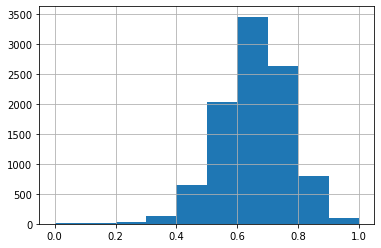

In [40]:
# animeList['scoreNorm'] = (animeList['score'] - animeList['score'].min()) / (animeList['score'].max() - animeList['score'].min())
animeList['scoreNorm'] = scaler.fit_transform(animeList[['score']])
print(animeList['scoreNorm'].describe())
animeList['scoreNorm'].hist()

count    9868.000000
mean        0.420291
std         0.193228
min         0.000000
25%         0.271974
50%         0.394192
75%         0.557663
max         1.000000
Name: membersLogNorm, dtype: float64


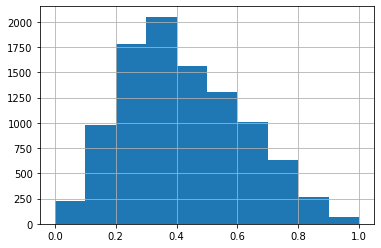

In [41]:
# animeList['membersLogNorm'] = (animeList['members_log'] - animeList['members_log'].min()) / (animeList['members_log'].max() - animeList['members_log'].min())
animeList['membersLogNorm'] = scaler.fit_transform(animeList[['members_log']])
print(animeList['membersLogNorm'].describe())
animeList['membersLogNorm'].hist()

Gerando outro dataset normalizado

In [42]:
animeListNorm = pd.DataFrame()
animeListNorm['title'] = animeList['title']
animeListNorm['members'] = scaler.fit_transform(animeList[['members']])
animeListNorm['favorites'] = scaler.fit_transform(animeList[['favorites']])
animeListNorm['episodes'] = scaler.fit_transform(animeList[['episodes']])
animeListNorm['score'] = animeList['score']
animeListNorm['scoreNorm'] = scaler.fit_transform(animeList[['score']])
animeListNorm.head()

,title,members,favorites,episodes,score,scoreNorm
0,Haikyuu!! Second Season,0.310238,0.073638,0.013438,8.78,0.940217
1,Shigatsu wa Kimi no Uso,0.552702,0.383489,0.011758,8.78,0.940217
2,Made in Abyss,0.333283,0.163512,0.006719,8.77,0.938859
3,Fullmetal Alchemist: Brotherhood,0.870886,1.000000,0.035274,9.22,1.000000
4,Kizumonogatari III: Reiketsu-hen,0.121661,0.024933,0.000000,8.82,0.945652


#### Multivariada

Usar o MultiLabelBinarizer para realizar o one hot encoding das listas de generos

In [43]:
mlb = MultiLabelBinarizer()
tempAnimeList = animeList.copy()
tempAnimeList = tempAnimeList.join(
    pd.DataFrame(mlb.fit_transform(tempAnimeList.pop('genresList')),
                 columns=mlb.classes_,
                 index=tempAnimeList.index))

In [44]:
tempAnimeList.head()

,title,studios,genres,source,score,members,favorites,episodes,studiosList,categoryByMembers,...,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi,Yuri
0,Haikyuu!! Second Season,['Production I.G'],"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",Manga,8.78,697848,12042,25.0,[Production I.G],Diamond,...,0,0,1,0,0,0,0,0,0,0
1,Shigatsu wa Kimi no Uso,['A-1 Pictures'],"['Drama', 'Music', 'Romance', 'School', 'Shoun...",Manga,8.78,1243086,62708,22.0,[A-1 Pictures],Diamond,...,0,0,0,0,0,0,0,0,0,0
2,Made in Abyss,['Kinema Citrus'],"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",Web manga,8.77,749670,26738,13.0,[Kinema Citrus],Diamond,...,0,0,0,0,0,0,0,0,0,0
3,Fullmetal Alchemist: Brotherhood,['Bones'],"['Action', 'Military', 'Adventure', 'Comedy', ...",Manga,9.22,1958597,163518,64.0,[Bones],Diamond,...,0,0,0,0,0,0,0,0,0,0
4,Kizumonogatari III: Reiketsu-hen,['Shaft'],"['Action', 'Mystery', 'Supernatural', 'Vampire']",Light novel,8.82,273788,4078,1.0,[Shaft],Diamond,...,0,0,0,0,1,0,0,1,0,0


In [45]:
# Dropar as colunas que não númericas e as geradas pelo log
tempAnimeList = tempAnimeList.drop(columns=['title', 'studios', 'genres','source', 'studiosList', 'categoryByMembers', 'studio', 'members_log'])
# Atribuir os valores normalizados com o dataset processado acima
tempAnimeList['members'] = animeListNorm['members']
tempAnimeList['favorites'] = animeListNorm['favorites']
tempAnimeList['episodes'] = animeListNorm['episodes']
tempAnimeList['score'] = animeListNorm['scoreNorm']

In [46]:
clf = IsolationForest(random_state=2020, behaviour="new")
clf.fit(tempAnimeList)

/Users/lionliu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


IsolationForest(behaviour='new', bootstrap=False, contamination='legacy',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=2020, verbose=0, warm_start=False)

In [47]:
scores = clf.predict(tempAnimeList)

In [48]:
scores

array([-1, -1, -1, ...,  1,  1,  1])

In [49]:
tempAnimeList = animeList.copy()
tempAnimeList['outlier'] = scores
tempAnimeList[tempAnimeList['outlier'] == -1]

,title,studios,genres,source,score,members,favorites,episodes,studiosList,genresList,categoryByMembers,studio,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm,outlier
0,Haikyuu!! Second Season,['Production I.G'],"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",Manga,8.78,697848,12042,25.0,[Production I.G],"[Comedy, Sports, Drama, School, Shounen]",Diamond,Production I.G,302,5.843761,-1.763062,0.940217,0.874277,-1
1,Shigatsu wa Kimi no Uso,['A-1 Pictures'],"['Drama', 'Music', 'Romance', 'School', 'Shoun...",Manga,8.78,1243086,62708,22.0,[A-1 Pictures],"[Drama, Music, Romance, School, Shounen]",Diamond,A-1 Pictures,6,6.094501,-1.297178,0.940217,0.936305,-1
2,Made in Abyss,['Kinema Citrus'],"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",Web manga,8.77,749670,26738,13.0,[Kinema Citrus],"[Sci-Fi, Adventure, Mystery, Drama, Fantasy]",Diamond,Kinema Citrus,202,5.874870,-1.447741,0.938859,0.881973,-1
3,Fullmetal Alchemist: Brotherhood,['Bones'],"['Action', 'Military', 'Adventure', 'Comedy', ...",Manga,9.22,1958597,163518,64.0,[Bones],"[Action, Military, Adventure, Comedy, Drama, M...",Diamond,Bones,67,6.291945,-1.078380,1.000000,0.985149,-1
5,Mob Psycho 100 II,['Bones'],"['Action', 'Slice of Life', 'Comedy', 'Superna...",Web manga,8.86,674704,16763,13.0,[Bones],"[Action, Slice of Life, Comedy, Supernatural]",Diamond,Bones,67,5.829113,-1.604762,0.951087,0.870653,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18869,Bai She: Yuan Qi,['Light Chaser Animation Studios'],"['Action', 'Adventure', 'Demons', 'Drama', 'Fa...",Original,7.49,3052,12,1.0,[Light Chaser Animation Studios],"[Action, Adventure, Demons, Drama, Fantasy, Hi...",Silver,Light Chaser Animation Studios,217,3.484585,-2.405403,0.764946,0.290661,-1
18876,Mahou no Tenshi Creamy Mami,['Studio Pierrot'],"['Comedy', 'Fantasy', 'Magic', 'Romance', 'Sch...",Original,7.14,9748,106,52.0,[Studio Pierrot],"[Comedy, Fantasy, Magic, Romance, School, Sci-...",Gold,Studio Pierrot,399,3.988916,-1.963610,0.717391,0.415423,-1
18881,Wan Jie Xian Zong 2nd Season,['Unknown'],"['Action', 'Adventure', 'Historical', 'Demons'...",Web manga,7.32,1184,6,40.0,[Unknown],"[Action, Adventure, Historical, Demons, Romanc...",Bronze,Unknown,471,3.073352,-2.295200,0.741848,0.188930,-1
18897,Uta no☆Prince-sama♪ Maji Love 1000%,['A-1 Pictures'],"['Harem', 'Music', 'Comedy', 'Romance', 'Schoo...",Visual novel,7.13,159499,1781,13.0,[A-1 Pictures],"[Harem, Music, Comedy, Romance, School, Shoujo]",Diamond,A-1 Pictures,6,5.202758,-1.952094,0.716033,0.715705,-1


In [50]:
tempAnimeList = tempAnimeList[tempAnimeList['outlier'] != -1]

In [51]:
print(len(tempAnimeList))
tempAnimeList.head()

8881


,title,studios,genres,source,score,members,favorites,episodes,studiosList,genresList,categoryByMembers,studio,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm,outlier
4,Kizumonogatari III: Reiketsu-hen,['Shaft'],"['Action', 'Mystery', 'Supernatural', 'Vampire']",Light novel,8.82,273788,4078,1.0,[Shaft],"[Action, Mystery, Supernatural, Vampire]",Diamond,Shaft,334,5.437414,-1.826967,0.945652,0.773754,1
8,Owarimonogatari 2nd Season,['Shaft'],"['Mystery', 'Comedy', 'Supernatural', 'Vampire']",Light novel,8.93,240981,5280,7.0,[Shaft],"[Mystery, Comedy, Supernatural, Vampire]",Diamond,Shaft,334,5.381983,-1.659349,0.960598,0.760042,1
17,Kaguya-hime no Monogatari,['Studio Ghibli'],"['Fantasy', 'Historical']",Other,8.25,129114,1369,1.0,[Studio Ghibli],"[Fantasy, Historical]",Diamond,Studio Ghibli,379,5.110973,-1.974570,0.868207,0.692999,1
19,Nodame Cantabile: Finale - Mine to Kiyora no S...,['J.C.Staff'],"['Comedy', 'Josei', 'Music', 'Romance']",Manga,7.84,35505,33,1.0,[J.C.Staff],"[Comedy, Josei, Music, Romance]",Platinum,J.C.Staff,180,4.550290,-3.031776,0.812500,0.554297,1
22,Noragami OVA,['Bones'],"['Action', 'Adventure', 'Comedy', 'Supernatura...",Manga,7.79,231947,392,2.0,[Bones],"[Action, Adventure, Comedy, Supernatural, Shou...",Diamond,Bones,67,5.365389,-2.772103,0.805707,0.755937,1


Foram 235 outliers detectados, porém este dataset não será utilizado na análise exploratória.

# Amostra de dados e resultados


## Exploratory Data Analysis

### Distribuição dos scores

Pelo gráfico, conseguimos ver a média de 6,68 com desvio padrão de 0,83

6.6896351844345485
0.8358126341267844


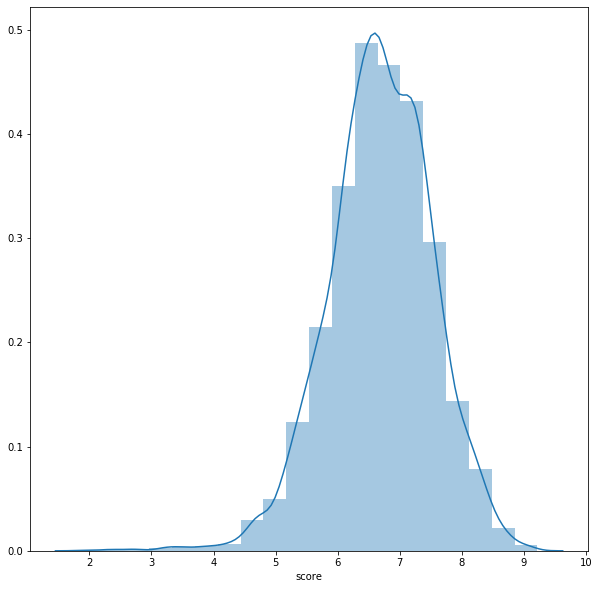

In [52]:
plt.figure(figsize=(10,10))
rating= animeList.score.astype(float)
print(animeList.score.astype(float).mean())
print(animeList.score.astype(float).std())
sns.distplot(rating, bins=20)

### Top 10 animes por quantidade de membros

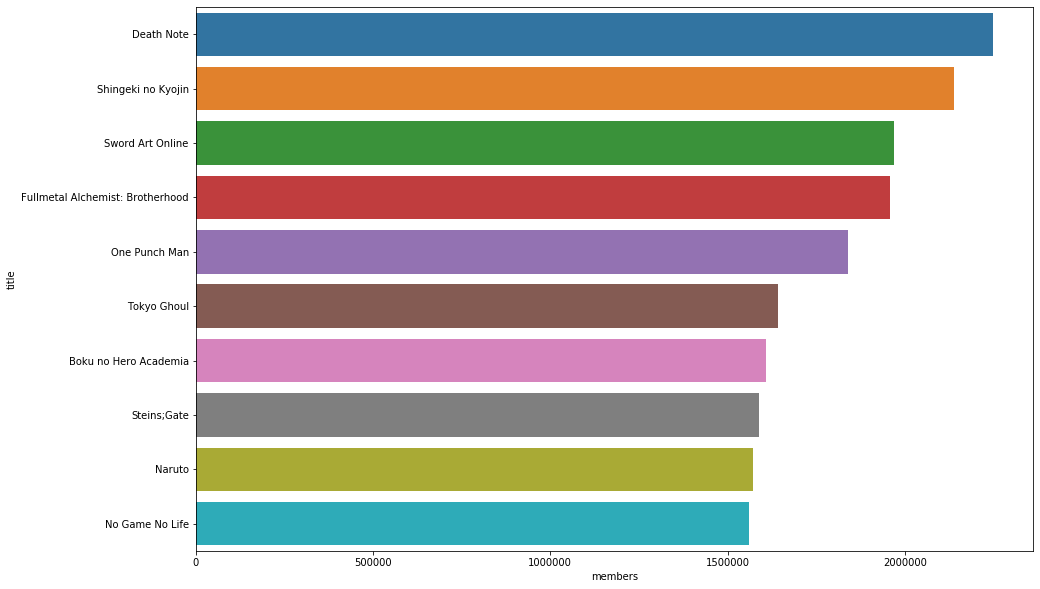

In [53]:
mostMembers = animeList.sort_values('members', ascending=False).head(10).set_index('title')
plt.figure(figsize=(15,10))
sns.barplot(mostMembers['members'], mostMembers.index)

O primeiro anime **Death Note** está muito na frente em relação aos demais, principalmente a partir do **Tokyo Ghoul** onde a diferença da margem é mais significativa

### Análise dos Gêneros

In [54]:
tempGenres = animeList.explode("genresList")
tempGenres['genresList'] = tempGenres['genresList'].astype('category')

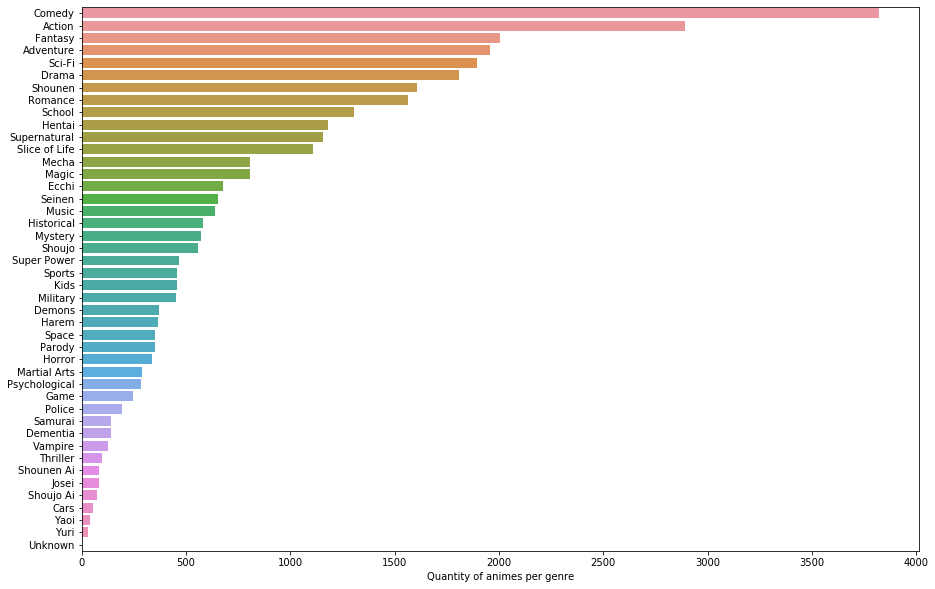

In [55]:
countGenres = tempGenres['genresList'].value_counts()
plt.figure(figsize=(15,10))
sns.barplot(x=countGenres.values, y=countGenres.index, orient="h", order=countGenres.index)
plt.xlabel("Quantity of animes per genre")
plt.show()

O gênero com a maior quantidade de animes é o de **comédia**, seguido de **ação**. Depois a margem aumenta significativamente em relação a **fantasia**.

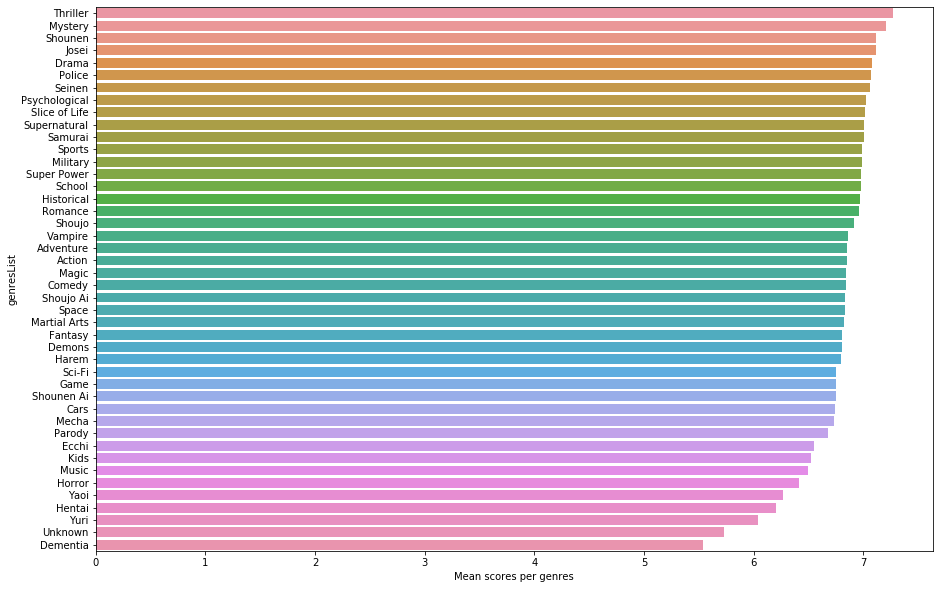

In [56]:
meanGenres = tempGenres.groupby("genresList").score.mean().sort_values(ascending=False)
plt.figure(figsize=(15,10))
sns.barplot(x=meanGenres.values, y = meanGenres.index,orient="h", order=meanGenres.index)
plt.xlabel("Mean scores per genres")
plt.show()

Os animes de **thriller** e **mistério** são os com maior nota em média, seguido de **shounen**, este que é um dos gêneros mais famosos do mercado. No final da lista, os animes considerados +18 são os que tem menor nota. 

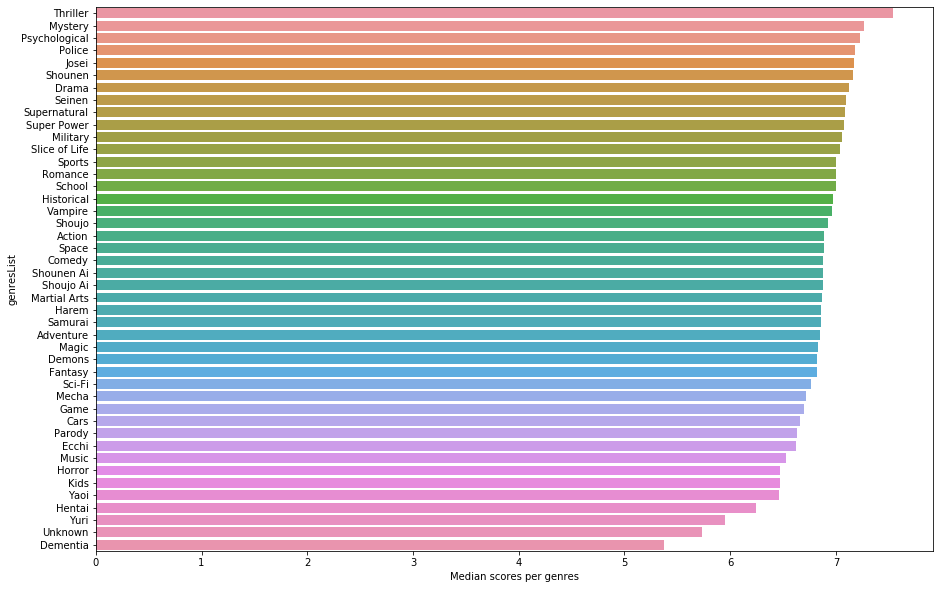

In [57]:
medianGenres = tempGenres.groupby("genresList").score.median().sort_values(ascending=False)
plt.figure(figsize=(15,10))
sns.barplot(x=medianGenres.values, y = medianGenres.index,orient="h", order=medianGenres.index)
plt.xlabel("Median scores per genres")
plt.show()

### Análise dos Estúdios

In [58]:
tempStudios = animeList.explode("studiosList")
tempStudios['studiosList'] = tempStudios['studiosList'].astype('category')

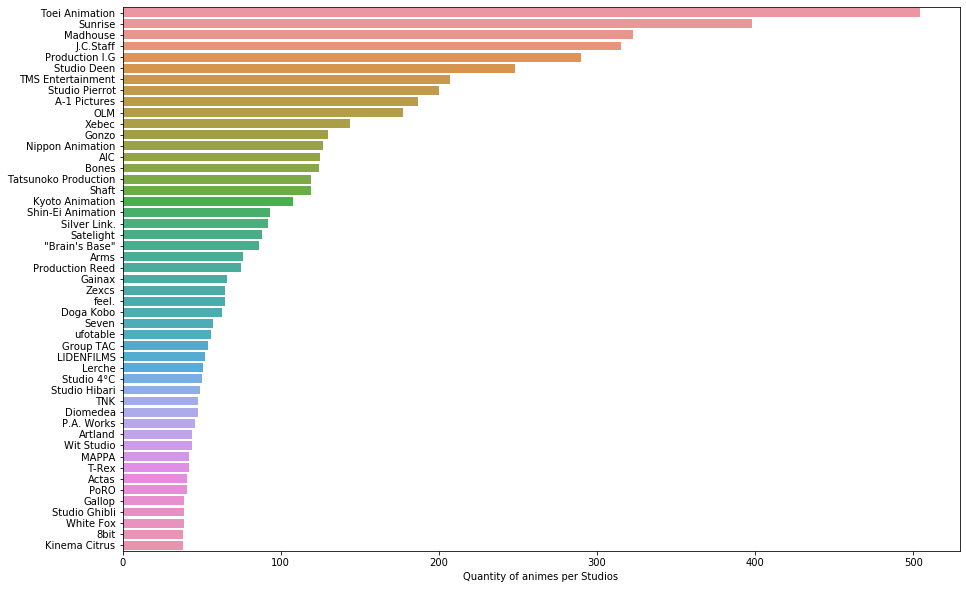

In [59]:
countStudios = tempStudios['studiosList'].value_counts()[1:50]
plt.figure(figsize=(15,10))
sns.barplot(x=countStudios.values, y=countStudios.index, orient="h", order=countStudios.index)
plt.xlabel("Quantity of animes per Studios")
plt.show()

Os estúdios da **Toei**, **Sunrise** e **Madhouse** são os que mais produziram animes. Isso se deve ao seu tempo no mercado. A **Toei** produz animes desde 1948, a **Sunrise** e a **Madhouse** desde 1972.

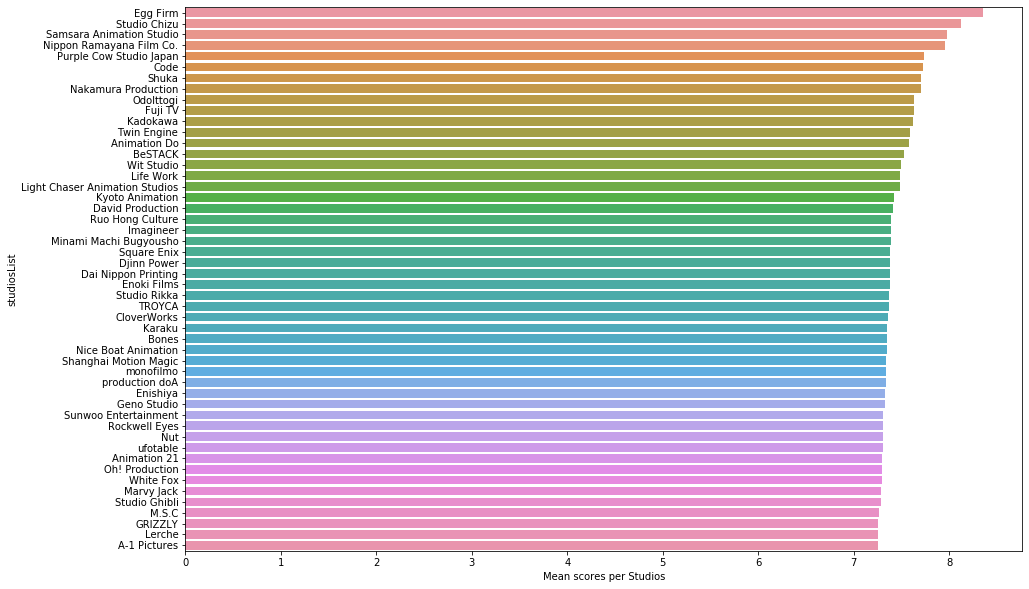

In [60]:
meanStudios = tempStudios.groupby("studiosList").score.mean().sort_values(ascending=False)[:50]
plt.figure(figsize=(15,10))
sns.barplot(x=meanStudios.values, y=meanStudios.index,orient="h", order=meanStudios.index)
plt.xlabel("Mean scores per Studios")
plt.show()

### Distribuição por Origem

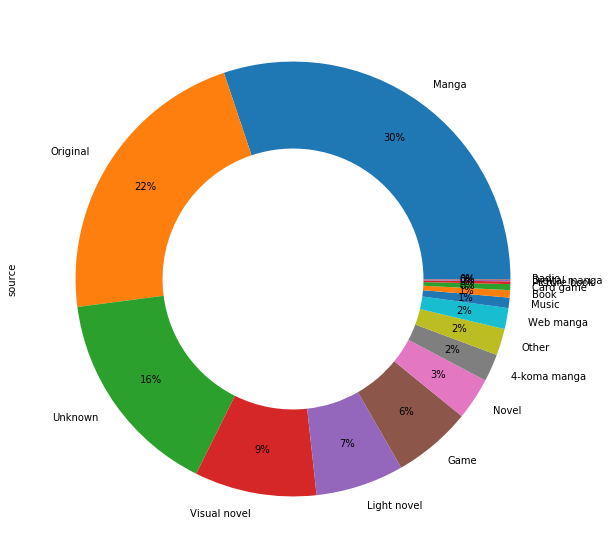

In [61]:
animeList.source.value_counts().plot.pie(autopct="%.0f%%",figsize=(15,10),pctdistance=0.8,
wedgeprops=dict(width=0.4))
plt.show()

Pela distribuição, os animes oriundos de mangás (quadrinhos japoneses) são maioria, seguido por anime de roteiros originais. A grande proporção de Unknown se deve ao fato do MyAnimeList não ter o campo de origem preenchido.

### Relação de episódios por score

In [62]:
animeList['episodes'].describe()

count    9868.000000
mean       12.277868
std        37.607328
min         1.000000
25%         1.000000
50%         3.000000
75%        12.000000
max      1787.000000
Name: episodes, dtype: float64

Plotar os animes com episodios menor-igual a 50, pois é onde se encontra a maioria dos animes. 

<Figure size 1080x720 with 0 Axes>

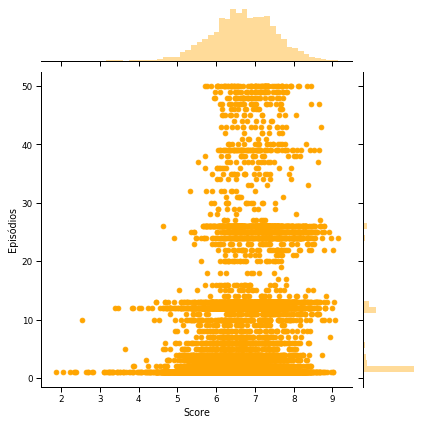

In [63]:
temp = animeList[animeList['episodes'] <= 50]
plt.figure(figsize=(15,10))
sns.set_context('paper')
ax = sns.jointplot(x="score", y="episodes", data = temp, color = 'orange')
ax.set_axis_labels("Score", "Episódios")

Pelo gráfico, não é possivel visualizar uma correlação entre a quantidade de episodios para uma nota positiva. Para notas ruins (<= 4), pode ser observado que a maioria possuem apenas 1 episódio, sendo muito provavelmente curta-metragens, clipes ou comerciais.

Também é possivel detectar picos próximos de 12 e 24 episódios. Isso se deve porque a maioria dos animes são lançados por temporada de 3 ou 6 meses semanalmente, resultando em 12 ou 24 episódios.

#### Relação do score pelos quantis dos membros

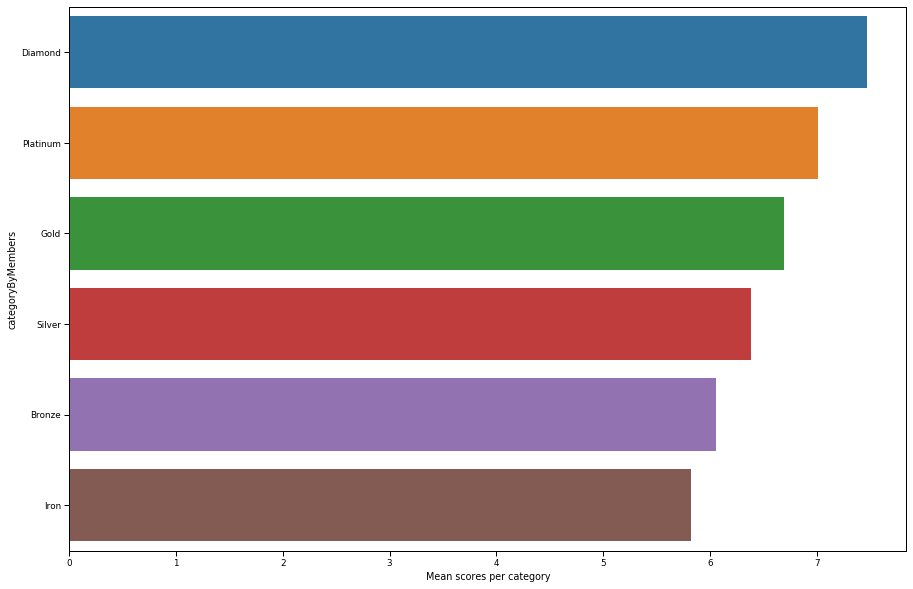

In [64]:
meanCategory = tempStudios.groupby("categoryByMembers").score.mean().sort_values(ascending=False)
plt.figure(figsize=(15,10))
sns.barplot(x=meanCategory.values, y=meanCategory.index,orient="h", order=meanCategory.index)
plt.xlabel("Mean scores per category")
plt.show()

Pelo gráfico acima das categorias de quantidade de membros divididos em 6 quantis, é possivel visualizar que a média do score sobe a medida que a quantidade de membros é maior. Isso poderá ser observado também nos gráficos de correlação abaixo.

## Covariancias e correlações

In [65]:
elements = ['score', 'members', 'favorites', 'episodes','favorite_per_member']

### Matriz de dispersão

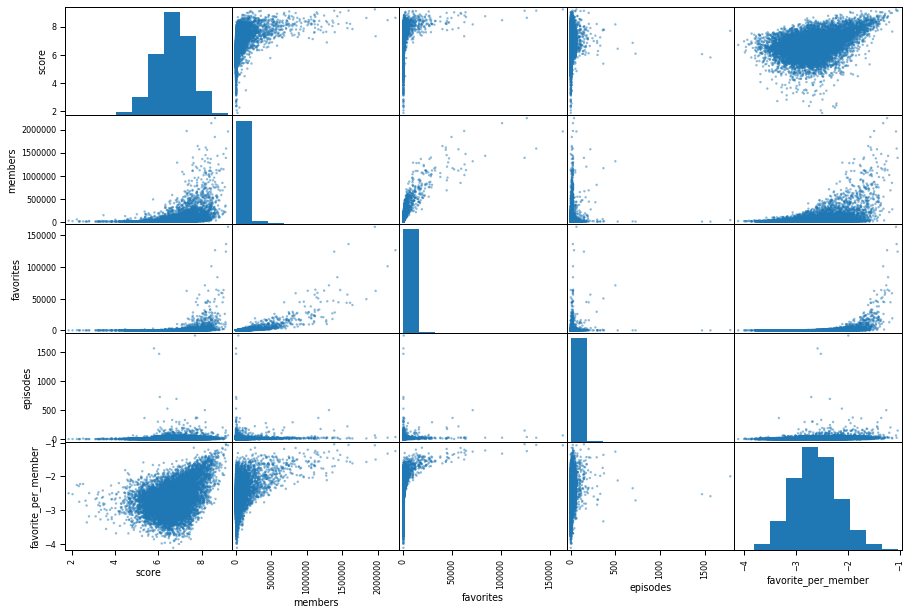

In [66]:
pd.plotting.scatter_matrix(animeList[elements], figsize=(15, 10));

Só pela matriz de dispersão, é possivel notar que a razão de favoritos por membros aparenta crescer "linearmente" em relação ao score

### Pearson

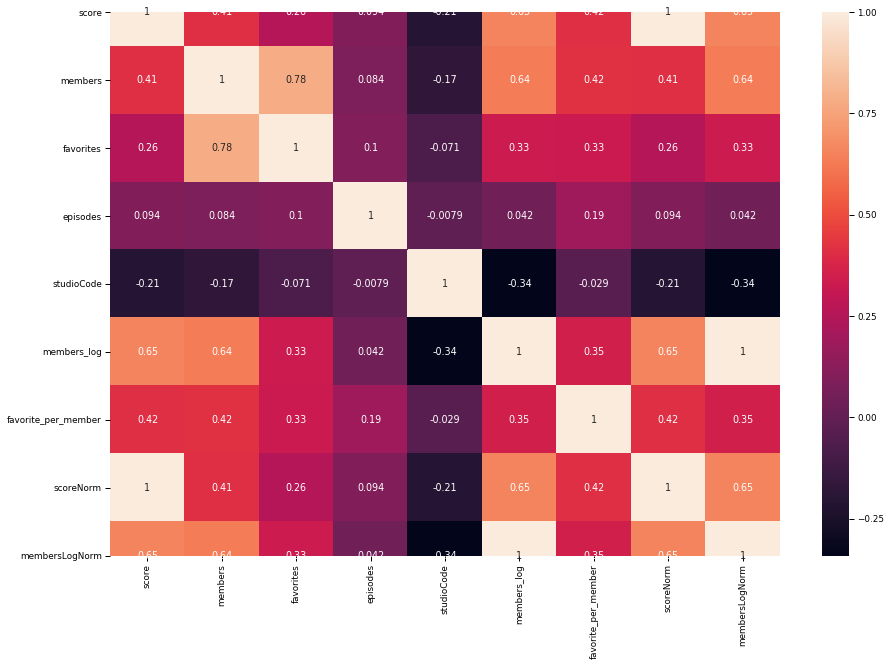

In [67]:
figure = plt.figure(figsize=(15,10))
sns.heatmap(animeList.corr(method='pearson'), annot=True)
plt.show()

### Spearman

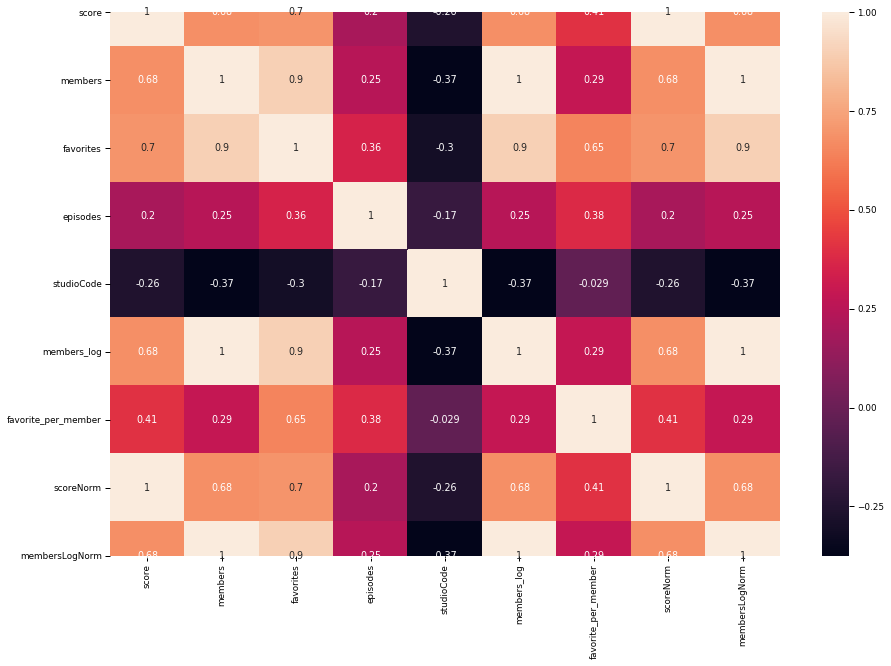

In [68]:
figure = plt.figure(figsize=(15,10))
sns.heatmap(animeList.corr(method='spearman'), annot=True)
plt.show()

A partir das correlações apresentadas, vemos que:
- A quantidade de favoritos varia de acordo com a quantidade de membros
- O Score é influenciado pela quantidade de favoritos
- Pouco importa a quantidade de episódios pra determinar o score

### Covariância

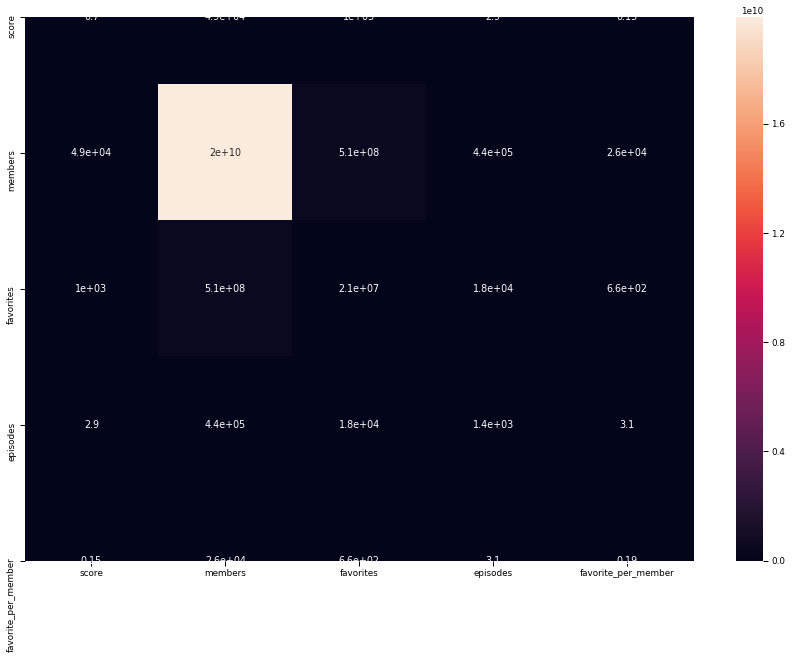

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
score,0.698583,4.876124e+04,9.988254e+02,2.943966,-2.677545e+01,0.427474,0.152205,0.094916,0.105749
members,48761.240511,1.990167e+10,5.093160e+08,444881.841398,-3.699977e+06,70102.314782,26009.030920,6625.168548,17341.980443
favorites,998.825385,5.093160e+08,2.118008e+07,17929.517913,-4.975544e+04,1187.938300,661.367158,135.709971,293.873360
episodes,2.943966,4.448818e+05,1.792952e+04,1414.311147,-4.520533e+01,1.226953,3.106130,0.399995,0.303525
studioCode,-26.775448,-3.699977e+06,-4.975544e+04,-45.205330,2.342898e+04,-40.807401,-1.958075,-3.637968,-10.094976


In [69]:
figure = plt.figure(figsize=(15,10))
sns.heatmap(animeList[elements].cov(), annot=True)
plt.show()
animeList.cov().head()

In [70]:
animeList.head()

,title,studios,genres,source,score,members,favorites,episodes,studiosList,genresList,categoryByMembers,studio,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
0,Haikyuu!! Second Season,['Production I.G'],"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",Manga,8.78,697848,12042,25.0,[Production I.G],"[Comedy, Sports, Drama, School, Shounen]",Diamond,Production I.G,302,5.843761,-1.763062,0.940217,0.874277
1,Shigatsu wa Kimi no Uso,['A-1 Pictures'],"['Drama', 'Music', 'Romance', 'School', 'Shoun...",Manga,8.78,1243086,62708,22.0,[A-1 Pictures],"[Drama, Music, Romance, School, Shounen]",Diamond,A-1 Pictures,6,6.094501,-1.297178,0.940217,0.936305
2,Made in Abyss,['Kinema Citrus'],"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",Web manga,8.77,749670,26738,13.0,[Kinema Citrus],"[Sci-Fi, Adventure, Mystery, Drama, Fantasy]",Diamond,Kinema Citrus,202,5.874870,-1.447741,0.938859,0.881973
3,Fullmetal Alchemist: Brotherhood,['Bones'],"['Action', 'Military', 'Adventure', 'Comedy', ...",Manga,9.22,1958597,163518,64.0,[Bones],"[Action, Military, Adventure, Comedy, Drama, M...",Diamond,Bones,67,6.291945,-1.078380,1.000000,0.985149
4,Kizumonogatari III: Reiketsu-hen,['Shaft'],"['Action', 'Mystery', 'Supernatural', 'Vampire']",Light novel,8.82,273788,4078,1.0,[Shaft],"[Action, Mystery, Supernatural, Vampire]",Diamond,Shaft,334,5.437414,-1.826967,0.945652,0.773754


# Testes de normalidade e hipótese

In [71]:
score_notna = animeList[animeList['score'].notna()].score
members_notna = animeList[animeList['members'].notna()].members
favorites_notna = animeList[animeList['favorites'].notna()].favorites

In [72]:
def generate_anderson(data):
    result = stats.anderson(data)
    print('Statistic: %.3f' % result.statistic)
    p = 0
    for i in range(len(result.critical_values)):
      sl, cv = result.significance_level[i], result.critical_values[i]
      if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
      else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

A análise por Anderson se viu necessária para verificação de normalidade, pela grande quantidade de dados presente na coleta, pois análise por Shapiro demonstra ser imprecisa para 
N > 5000

Statistic: 8.878
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


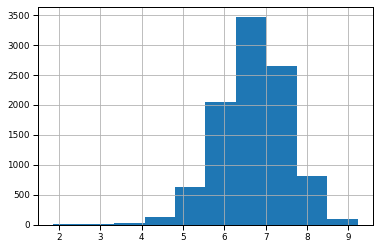

In [73]:
animeList.score.hist()
generate_anderson(animeList.score)

Mesmo que o score aparenta ter um histograma com uma curva de Gauss, pelo teste de Anderson, a hipotese nula foi rejeitada.

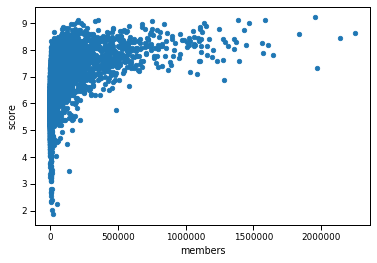

In [74]:
animeList.plot.scatter(x='members',y='score')

Statistic: 1980.909
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


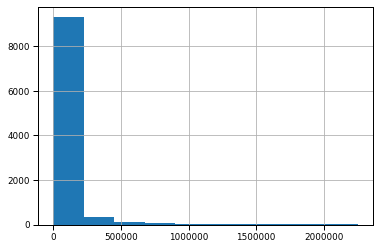

In [75]:
members_notna.hist()
generate_anderson(members_notna)

Statistic: 3079.514
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


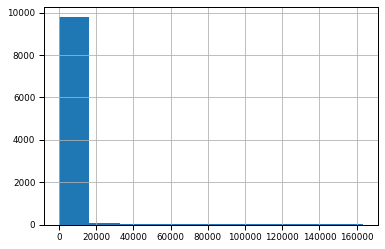

In [76]:
favorites_notna.hist()
generate_anderson(favorites_notna)

Statistic: 1980.909
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


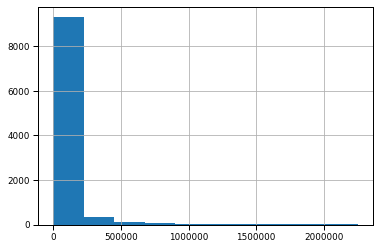

In [77]:
animeList.members.hist()
generate_anderson(animeList.members)

Nenhum dos dados seguem uma normal, logo o teste de hipotese a ser utilizado seria o mann-whitney, pois a comparação seria entre membros não-pariados e não-paremétricos

### Analise Comédia e Ação (Mais quantitativos)

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,2923.000000,2.923000e+03,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000
mean,6.804653,5.541687e+04,572.511803,15.300376,293.926103,4.128243,-2.700953,0.671828,0.449890
std,0.790188,1.181553e+05,2771.470599,46.928070,153.805895,0.762940,0.465299,0.107362,0.188737
min,2.040000,2.050000e+02,1.000000,1.000000,0.000000,2.311754,-4.115377,0.024457,0.000525
25%,6.320000,3.478000e+03,4.000000,1.000000,180.000000,3.541330,-3.027854,0.605978,0.304699
50%,6.820000,1.268400e+04,19.000000,9.000000,330.000000,4.103256,-2.722634,0.673913,0.443709
75%,7.340000,4.941300e+04,131.000000,13.000000,438.000000,4.693841,-2.402936,0.744565,0.589808
max,8.960000,1.561292e+06,58610.000000,1787.000000,509.000000,6.193484,-1.150317,0.964674,0.960792


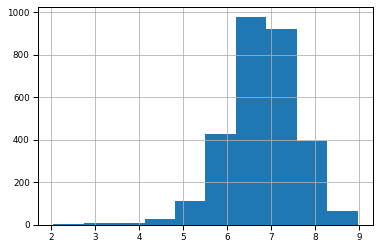

In [78]:
# Amostra de dados que são de Comédia, mas não de ação.
animeList[~animeList['genres'].str.contains('Action') & animeList['genres'].str.contains('Comedy')].score.hist()
animeList[~animeList['genres'].str.contains('Action') & animeList['genres'].str.contains('Comedy')].describe()

In [79]:
# Melhor anime cotado somente de Comedia
animeList[(~animeList['genres'].str.contains('Action') & animeList['genres'].str.contains('Comedy')) & (animeList.score == 8.96)]

,title,studios,genres,source,score,members,favorites,episodes,studiosList,genresList,categoryByMembers,studio,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
14,Clannad: After Story,['Kyoto Animation'],"['Slice of Life', 'Comedy', 'Supernatural', 'D...",Visual novel,8.96,841125,58610,24.0,[Kyoto Animation],"[Slice of Life, Comedy, Supernatural, Drama, R...",Diamond,Kyoto Animation,206,5.924861,-1.156889,0.964674,0.894339


In [80]:
# Pior anime cotado somente de Comedia
animeList[(~animeList['genres'].str.contains('Action') & animeList['genres'].str.contains('Comedy')) & (animeList.score == 2.04)]

,title,studios,genres,source,score,members,favorites,episodes,studiosList,genresList,categoryByMembers,studio,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
9590,Utsu Musume Sayuri,['Unknown'],"['Comedy', 'Dementia']",Original,2.04,11435,34,1.0,[Unknown],"[Comedy, Dementia]",Gold,Unknown,471,4.058236,-2.526757,0.024457,0.432572


,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,1992.000000,1.992000e+03,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000
mean,6.787395,7.419351e+04,931.580823,12.124498,300.298193,4.178519,-2.601503,0.669483,0.462328
std,0.821804,1.755990e+05,5447.587732,17.357660,155.692818,0.803479,0.426025,0.111658,0.198766
min,3.160000,3.320000e+02,1.000000,1.000000,0.000000,2.521138,-3.968109,0.176630,0.052323
25%,6.290000,3.448750e+03,5.000000,1.000000,180.000000,3.537662,-2.903585,0.601902,0.303792
50%,6.810000,1.308550e+04,28.000000,4.000000,327.000000,4.116789,-2.620656,0.672554,0.447057
75%,7.360000,6.148025e+04,188.000000,13.000000,450.000000,4.788736,-2.318483,0.747283,0.613284
max,9.120000,2.138732e+06,124303.000000,193.000000,509.000000,6.330156,-1.047107,0.986413,0.994602


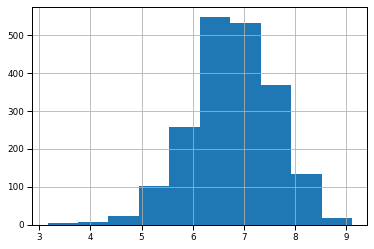

In [81]:
# Amostra de dados que são de Ação, mas não de comédia.
animeList[animeList['genres'].str.contains('Action') & ~animeList['genres'].str.contains('Comedy')].score.hist()
animeList[animeList['genres'].str.contains('Action') & ~animeList['genres'].str.contains('Comedy')].describe()

In [82]:
# Melhor anime cotado somente de Ação
animeList[(animeList['genres'].str.contains('Action') & ~animeList['genres'].str.contains('Comedy')) & (animeList.score == 9.12)]

,title,studios,genres,source,score,members,favorites,episodes,studiosList,genresList,categoryByMembers,studio,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
769,Hunter x Hunter (2011),['Madhouse'],"['Action', 'Adventure', 'Fantasy', 'Shounen', ...",Manga,9.12,1385442,124303,148.0,[Madhouse],"[Action, Adventure, Fantasy, Shounen, Super Po...",Diamond,Madhouse,224,6.141588,-1.047107,0.986413,0.947954


In [83]:
# Pior anime cotado somente de Ação
animeList[(animeList['genres'].str.contains('Action') & ~animeList['genres'].str.contains('Comedy')) & (animeList.score == 3.16)]

,title,studios,genres,source,score,members,favorites,episodes,studiosList,genresList,categoryByMembers,studio,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
9476,Soujuu Senshi Psychic Wars,['Toei Animation'],"['Action', 'Super Power', 'Demons', 'Seinen']",Unknown,3.16,3096,7,1.0,[Toei Animation],"[Action, Super Power, Demons, Seinen]",Silver,Toei Animation,450,3.490801,-2.645703,0.17663,0.292199


In [84]:
# Diferença de descrição
animeList[animeList['genres'].str.contains('Action') & ~animeList['genres'].str.contains('Comedy')].describe() - animeList[~animeList['genres'].str.contains('Action') & animeList['genres'].str.contains('Comedy')].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,-931.000000,-931.000000,-931.000000,-931.000000,-931.000000,-931.000000,-931.000000,-931.000000,-931.000000
mean,-0.017258,18776.644402,359.069020,-3.175878,6.372089,0.050276,0.099451,-0.002345,0.012437
std,0.031616,57443.720267,2676.117134,-29.570410,1.886923,0.040539,-0.039274,0.004296,0.010029
min,1.120000,127.000000,0.000000,0.000000,0.000000,0.209384,0.147268,0.152174,0.051798
25%,-0.030000,-29.250000,1.000000,0.000000,0.000000,-0.003668,0.124269,-0.004076,-0.000907
50%,-0.010000,401.500000,9.000000,-5.000000,-3.000000,0.013532,0.101978,-0.001359,0.003348
75%,0.020000,12067.250000,57.000000,0.000000,12.000000,0.094895,0.084453,0.002717,0.023475
max,0.160000,577440.000000,65693.000000,-1594.000000,0.000000,0.136672,0.103210,0.021739,0.033810


In [85]:
animeList[~animeList['genres'].str.contains('Action') & animeList['genres'].str.contains('Comedy')].describe()/animeList[animeList['genres'].str.contains('Action') & ~animeList['genres'].str.contains('Comedy')].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,1.467369,1.467369,1.467369,1.467369,1.467369,1.467369,1.467369,1.467369,1.467369
mean,1.002543,0.746923,0.614559,1.261939,0.978781,0.987968,1.038228,1.003502,0.973099
std,0.961529,0.672870,0.508752,2.703594,0.987880,0.949545,1.092187,0.961529,0.949545
min,0.645570,0.617470,1.000000,1.000000,NaN,0.916949,1.037113,0.138462,0.010041
25%,1.004769,1.008481,0.800000,1.000000,1.000000,1.001037,1.042799,1.006772,1.002987
50%,1.001468,0.969317,0.678571,2.250000,1.009174,0.996713,1.038913,1.002020,0.992512
75%,0.997283,0.803722,0.696809,1.000000,0.973333,0.980184,1.036426,0.996364,0.961722
max,0.982456,0.730008,0.471509,9.259067,1.000000,0.978409,1.098567,0.977961,0.966006


In [86]:
# Score
stats.mannwhitneyu(animeList[~animeList['genres'].str.contains('Action') & animeList['genres'].str.contains('Comedy')].score,animeList[~animeList['genres'].str.contains('Comedy') & animeList['genres'].str.contains('Action')].score)

MannwhitneyuResult(statistic=2869396.0, pvalue=0.1954050976143436)

In [87]:
# Members
stats.mannwhitneyu(animeList[~animeList['genres'].str.contains('Action') & animeList['genres'].str.contains('Comedy')].members,animeList[~animeList['genres'].str.contains('Comedy') & animeList['genres'].str.contains('Action')].members)

MannwhitneyuResult(statistic=2830895.0, pvalue=0.04983532584370011)

A partir da comparação dos 2 gêneros mais populares, vemos que:
- A diferença entre scores não são tão absurdas
- Em mediana, animes de ação que não são comédia possui nota ligeiramente menor
- Animes de ação normalmente possuem uma comunidade maior, tanto em membros quanto em favoritos.
- Pelo teste de hipotese, vemos que os dados não são iguais, tendo o pvalue um valor pequeno

### Analise Shounen e Mistério (Maiores médias)

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,448.000000,4.480000e+02,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000
mean,7.122210,1.161803e+05,1662.209821,10.861607,277.984375,4.486876,-2.524514,0.714974,0.538609
std,0.841668,1.968453e+05,4890.060466,13.176433,151.803659,0.814832,0.509055,0.114357,0.201574
min,3.400000,2.970000e+02,1.000000,1.000000,0.000000,2.472756,-3.796297,0.209239,0.040354
25%,6.570000,6.902000e+03,8.750000,1.000000,180.000000,3.838973,-2.884395,0.639946,0.378330
50%,7.180000,3.650650e+04,90.000000,11.000000,299.500000,4.562370,-2.547478,0.722826,0.557285
75%,7.690000,1.455442e+05,737.500000,13.000000,428.000000,5.162993,-2.214631,0.792120,0.705868
max,8.930000,1.642167e+06,40001.000000,155.000000,509.000000,6.215417,-1.319633,0.960598,0.966218


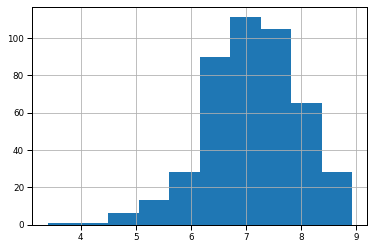

In [88]:
# Amostra de dados do que são de Mistério, mas não de Shounen (Ação para garotos adolescentes)
animeList[~animeList['genres'].str.contains('Shounen') & animeList['genres'].str.contains('Mystery')].score.hist()
animeList[~animeList['genres'].str.contains('Shounen') & animeList['genres'].str.contains('Mystery')].describe()

In [89]:
# Melhor anime cotado somente de Mistério
animeList[(~animeList['genres'].str.contains('Shounen') & animeList['genres'].str.contains('Mystery')) & (animeList.score == 8.93)]

,title,studios,genres,source,score,members,favorites,episodes,studiosList,genresList,categoryByMembers,studio,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
8,Owarimonogatari 2nd Season,['Shaft'],"['Mystery', 'Comedy', 'Supernatural', 'Vampire']",Light novel,8.93,240981,5280,7.0,[Shaft],"[Mystery, Comedy, Supernatural, Vampire]",Diamond,Shaft,334,5.381983,-1.659349,0.960598,0.760042


In [90]:
# Pior anime cotado somente de Mistério
animeList[(~animeList['genres'].str.contains('Shounen') & animeList['genres'].str.contains('Mystery')) & (animeList.score == 3.40)]

,title,studios,genres,source,score,members,favorites,episodes,studiosList,genresList,categoryByMembers,studio,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
9511,Vampire Holmes,['Studio! Cucuri'],"['Mystery', 'Comedy', 'Supernatural']",Game,3.4,15501,36,12.0,[Studio! Cucuri],"[Mystery, Comedy, Supernatural]",Platinum,Studio! Cucuri,416,4.19036,-2.634057,0.209239,0.465257


,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,1564.000000,1.564000e+03,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000
mean,7.064706,8.285123e+04,1268.487852,19.944373,312.106777,4.283786,-2.569491,0.707161,0.488369
std,0.712748,1.869745e+05,7129.948236,58.193162,150.328842,0.776183,0.452744,0.096841,0.192013
min,3.520000,3.500000e+02,1.000000,1.000000,0.000000,2.544068,-3.774079,0.225543,0.057995
25%,6.607500,4.698250e+03,9.000000,1.000000,180.000000,3.671935,-2.896962,0.645041,0.337008
50%,7.100000,1.820750e+04,38.500000,8.000000,368.000000,4.260250,-2.587797,0.711957,0.482546
75%,7.510000,7.324875e+04,241.500000,25.000000,450.000000,4.864799,-2.272374,0.767663,0.632100
max,9.220000,1.958597e+06,163518.000000,1787.000000,509.000000,6.291945,-1.047107,1.000000,0.985149


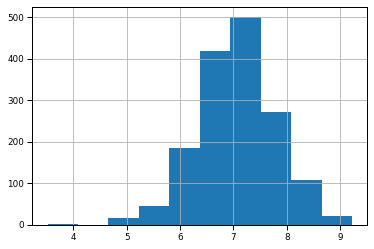

In [91]:
# Amostra de dados do que são de 'Ação para adolescentes masculinos', mas não de Mistério
animeList[animeList['genres'].str.contains('Shounen') & ~animeList['genres'].str.contains('Mystery')].score.hist()
animeList[(animeList['genres'].str.contains('Shounen') & ~animeList['genres'].str.contains('Mystery'))].describe()

In [92]:
# Melhor anime cotado somente de Luta
animeList[(animeList['genres'].str.contains('Shounen') & ~animeList['genres'].str.contains('Mystery')) & (animeList.score == 9.22)]

,title,studios,genres,source,score,members,favorites,episodes,studiosList,genresList,categoryByMembers,studio,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
3,Fullmetal Alchemist: Brotherhood,['Bones'],"['Action', 'Military', 'Adventure', 'Comedy', ...",Manga,9.22,1958597,163518,64.0,[Bones],"[Action, Military, Adventure, Comedy, Drama, M...",Diamond,Bones,67,6.291945,-1.07838,1.0,0.985149


In [93]:
# Pior anime cotado somente de Luta
animeList[(animeList['genres'].str.contains('Shounen') & ~animeList['genres'].str.contains('Mystery')) & (animeList.score == 3.52)]

,title,studios,genres,source,score,members,favorites,episodes,studiosList,genresList,categoryByMembers,studio,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
9520,Tenshi no Drop,['AIC Frontier'],"['Comedy', 'Ecchi', 'Shounen']",Web manga,3.52,12036,13,1.0,[AIC Frontier],"[Comedy, Ecchi, Shounen]",Gold,AIC Frontier,14,4.080482,-2.966539,0.225543,0.438075


In [94]:
animeList[animeList['genres'].str.contains('Shounen') & ~animeList['genres'].str.contains('Mystery')].describe() - animeList[~animeList['genres'].str.contains('Shounen') & animeList['genres'].str.contains('Mystery')].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,1116.000000,1116.000000,1116.00000,1116.000000,1116.000000,1116.000000,1116.000000,1116.000000,1116.000000
mean,-0.057504,-33329.076578,-393.72197,9.082766,34.122402,-0.203090,-0.044976,-0.007813,-0.050241
std,-0.128920,-9870.806226,2239.88777,45.016729,-1.474817,-0.038650,-0.056310,-0.017516,-0.009561
min,0.120000,53.000000,0.00000,0.000000,0.000000,0.071312,0.022218,0.016304,0.017641
25%,0.037500,-2203.750000,0.25000,0.000000,0.000000,-0.167038,-0.012567,0.005095,-0.041322
50%,-0.080000,-18299.000000,-51.50000,-3.000000,68.500000,-0.302120,-0.040319,-0.010870,-0.074739
75%,-0.180000,-72295.500000,-496.00000,12.000000,22.000000,-0.298194,-0.057744,-0.024457,-0.073767
max,0.290000,316430.000000,123517.00000,1632.000000,0.000000,0.076528,0.272527,0.039402,0.018932


In [95]:
# Porcentagens
animeList[animeList['genres'].str.contains('Shounen') & ~animeList['genres'].str.contains('Mystery')].describe()/animeList[~animeList['genres'].str.contains('Shounen') & animeList['genres'].str.contains('Mystery')].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,3.491071,3.491071,3.491071,3.491071,3.491071,3.491071,3.491071,3.491071,3.491071
mean,0.991926,0.713126,0.763133,1.836227,1.122749,0.954737,1.017816,0.989072,0.906722
std,0.846828,0.949855,1.458049,4.416458,0.990285,0.952567,0.889382,0.846828,0.952567
min,1.035294,1.178451,1.000000,1.000000,NaN,1.028839,0.994147,1.077922,1.437156
25%,1.005708,0.680708,1.028571,1.000000,1.000000,0.956489,1.004357,1.007962,0.890778
50%,0.988858,0.498747,0.427778,0.727273,1.228715,0.933780,1.015827,0.984962,0.865888
75%,0.976593,0.503275,0.327458,1.923077,1.051402,0.942244,1.026074,0.969125,0.895494
max,1.032475,1.192691,4.087848,11.529032,1.000000,1.012313,0.793483,1.041018,1.019593


In [96]:
# Score
stats.mannwhitneyu(animeList[~animeList['genres'].str.contains('Shounen') & animeList['genres'].str.contains('Mystery')].score,animeList[~animeList['genres'].str.contains('Mystery') & animeList['genres'].str.contains('Shounen')].score)

MannwhitneyuResult(statistic=329654.0, pvalue=0.028218261974737303)

In [97]:
# Members
stats.mannwhitneyu(animeList[~animeList['genres'].str.contains('Shounen') & animeList['genres'].str.contains('Mystery')].members,animeList[~animeList['genres'].str.contains('Mystery') & animeList['genres'].str.contains('Shounen')].members)

MannwhitneyuResult(statistic=296747.5, pvalue=3.8491041370489297e-07)

A partir da comparação dos 2° e 3° gêneros de maior media e mediana vemos que:
- Em maioria, o público prefere animes de Mistério que não são Shounen.
- Comunidades de animes de Mistério normalmente são maiores.
- Animes de mistério normalmente possuem score maior.
- Pelo teste de hipotese, vemos que os dados não são iguais, pois o p-value teve um valor pequeno, sendo a hipotese nula rejeitada

### Analise Egg Firm e Studio Chizu (Estúdios com as maiores médias)

In [98]:
animeList[animeList['studios'].str.contains('Egg Firm')].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,4.000000,4.000000,4.000000,4.000000,4.0,4.000000,4.000000,4.000000,4.000000
mean,8.350000,224329.000000,3590.250000,37.750000,180.0,5.234691,-2.221357,0.881793,0.723605
std,0.175689,179150.697115,5357.886423,55.715797,0.0,0.373953,0.498080,0.023871,0.092509
min,8.170000,77817.000000,198.000000,1.000000,180.0,4.891074,-2.653018,0.857337,0.638600
25%,8.215000,86586.750000,198.750000,4.750000,180.0,4.936672,-2.609062,0.863451,0.649880
50%,8.355000,181060.500000,1351.500000,15.000000,180.0,5.193707,-2.315659,0.882473,0.713466
75%,8.490000,318802.750000,4743.000000,48.000000,180.0,5.491726,-1.927954,0.900815,0.787190
max,8.520000,457378.000000,11460.000000,120.000000,180.0,5.660275,-1.601091,0.904891,0.828886


In [99]:
animeList[animeList['studios'].str.contains('Egg Firm')]

,title,studios,genres,source,score,members,favorites,episodes,studiosList,genresList,categoryByMembers,studio,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
504,Saiki Kusuo no Ψ-nan: Kanketsu-hen,"['J.C.Staff', 'Egg Firm']","['Comedy', 'School', 'Shounen', 'Slice of Life...",Manga,8.23,89510,199,1.0,"[J.C.Staff, Egg Firm]","[Comedy, School, Shounen, Slice of Life, Super...",Diamond,J.C.Staff,180,4.951872,-2.653018,0.865489,0.653640
606,Saiki Kusuo no Ψ-nan: Ψ-shidou-hen,"['J.C.Staff', 'Egg Firm']","['Comedy', 'School', 'Shounen', 'Slice of Life...",Manga,8.17,77817,198,6.0,"[J.C.Staff, Egg Firm]","[Comedy, School, Shounen, Slice of Life, Super...",Diamond,J.C.Staff,180,4.891074,-2.594409,0.857337,0.638600
691,Saiki Kusuo no Ψ-nan,"['J.C.Staff', 'Egg Firm']","['Comedy', 'School', 'Shounen', 'Slice of Life...",Manga,8.48,457378,11460,120.0,"[J.C.Staff, Egg Firm]","[Comedy, School, Shounen, Slice of Life, Super...",Diamond,J.C.Staff,180,5.660275,-1.601091,0.899457,0.828886
710,Saiki Kusuo no Ψ-nan 2,"['J.C.Staff', 'Egg Firm']","['Slice of Life', 'Comedy', 'Supernatural', 'S...",Manga,8.52,272611,2504,24.0,"[J.C.Staff, Egg Firm]","[Slice of Life, Comedy, Supernatural, School, ...",Diamond,J.C.Staff,180,5.435543,-2.036909,0.904891,0.773292


In [100]:
animeList[animeList['studio'] == 'Studio Chizu'].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,3.000000,3.000000,3.000000,3.0,3.0,3.000000,3.000000,3.000000,3.000000
mean,8.123333,304805.333333,4109.000000,1.0,365.0,5.354809,-2.138820,0.850996,0.753319
std,0.686319,244081.991991,4912.659463,0.0,0.0,0.447297,0.428050,0.093250,0.110653
min,7.350000,73848.000000,183.000000,1.0,365.0,4.868339,-2.605888,0.745924,0.632976
25%,7.855000,177119.500000,1354.500000,1.0,365.0,5.158051,-2.325609,0.814538,0.704645
50%,8.360000,280391.000000,2526.000000,1.0,365.0,5.447764,-2.045331,0.883152,0.776315
75%,8.510000,420284.000000,6072.000000,1.0,365.0,5.598045,-1.905286,0.903533,0.813491
max,8.660000,560177.000000,9618.000000,1.0,365.0,5.748325,-1.765241,0.923913,0.850668


In [101]:
animeList[animeList['studio'] == 'Studio Chizu']

,title,studios,genres,source,score,members,favorites,episodes,studiosList,genresList,categoryByMembers,studio,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
646,Bakemono no Ko,['Studio Chizu'],"['Adventure', 'Supernatural']",Original,8.36,280391,2526,1.0,[Studio Chizu],"[Adventure, Supernatural]",Diamond,Studio Chizu,365,5.447764,-2.045331,0.883152,0.776315
744,Ookami Kodomo no Ame to Yuki,['Studio Chizu'],"['Fantasy', 'Slice of Life']",Original,8.66,560177,9618,1.0,[Studio Chizu],"[Fantasy, Slice of Life]",Diamond,Studio Chizu,365,5.748325,-1.765241,0.923913,0.850668
12587,Mirai no Mirai,['Studio Chizu'],"['Adventure', 'Drama', 'Fantasy']",Original,7.35,73848,183,1.0,[Studio Chizu],"[Adventure, Drama, Fantasy]",Diamond,Studio Chizu,365,4.868339,-2.605888,0.745924,0.632976


In [102]:
animeList[animeList['genres'].str.contains('Comedy') & animeList['genres'].str.contains('Supernatural')].score.median()

7.21

In [103]:
#Score
stats.mannwhitneyu(animeList[animeList['studio'] == 'Studio Chizu'].score,animeList[animeList['studios'].str.contains('Egg Firm')].score)

MannwhitneyuResult(statistic=6.0, pvalue=0.4298418975993331)

In [104]:
#Membros
stats.mannwhitneyu(animeList[animeList['studio'] == 'Studio Chizu'].members,animeList[animeList['studios'].str.contains('Egg Firm')].members)

MannwhitneyuResult(statistic=5.0, pvalue=0.4298418975993331)

Para os estudios de maior média, não há tanto a se comparar, pela quantidade de animes criados por cada um, porém, é notável que:
- **Studio Chizu** normalmente é um estudio de filmes (Só realizou filmes até então)
- **Egg Firm**, juntamente a **J.C. Staff** produziram Saiki no Kusuo, um famoso anime lançado em 28 de Dezembro  de 2018 com maior foco em comédia e sobrenatural (poderes psiquicos), generos dos quais possuem uma média de score alta.
- **Studio Chizu** em maioria realiza filmes de Fantasia, onde 'Bakemono no Ko' é o único que não possui o gênero de fantasia no MyAnimeList, porém, ao nosso ver, pode ser considerado também deste genero, tendo em vista que se trata de um garoto que vai para um mundo onde há somente monstros.

### Amostra de dados quantitativos de gêneros de Toei Animation, Sunrise e Madhouse

In [105]:
# Quantidade de animes feitos por gênero pela 'Toei Animation'
tempGenres = animeList[(animeList['studio'] == 'Toei Animation')].explode("genresList")
tempGenres['genresList'] = tempGenres['genresList'].astype('category')
tempGenres['genresList'].value_counts()[1:10]

Adventure      224
Action         211
Comedy         207
Shounen        201
Sci-Fi         126
Drama          118
Shoujo         102
Magic           98
Super Power     57
Name: genresList, dtype: int64

In [106]:
# Quantidade de animes feitos por gênero pela 'Sunrise'
tempGenres = animeList[(animeList['studio'] == 'Sunrise')].explode("genresList")
tempGenres['genresList'] = tempGenres['genresList'].astype('category')
tempGenres['genresList'].value_counts()[1:10]

Action       213
Mecha        188
Comedy       110
Drama        103
Military      97
Adventure     95
Space         92
Shounen       87
Romance       44
Name: genresList, dtype: int64

In [107]:
# Quantidade de animes feitos por gênero pela 'Madhouse'
tempGenres = animeList[(animeList['studio'] == 'Madhouse')].explode("genresList")
tempGenres['genresList'] = tempGenres['genresList'].astype('category')
tempGenres['genresList'].value_counts()[1:10]

Comedy          120
Action          106
Sci-Fi           89
Adventure        84
Fantasy          71
Romance          65
Supernatural     54
Shounen          53
Seinen           41
Name: genresList, dtype: int64

Com o top 10 de animes mais feitos pelos estúdios 'Toei Animation','Sunrise' e 'Madhouse', temos alguns gêneros em comum como:
- Action    :[224,213,106]
- Comedy    :[207,110,120]
- Shounen   :[201,87  ,53]

### Analise Toei Animation e Sunrise

In [108]:
# Toei e Sunrise
stats.mannwhitneyu(animeList[(animeList['studio'] == 'Toei Animation') & (animeList['genres'].str.contains('Action'))].score,animeList[(animeList['studio'] == 'Sunrise') & (animeList['genres'].str.contains('Action'))].score)

MannwhitneyuResult(statistic=18896.5, pvalue=0.0023035286349483352)

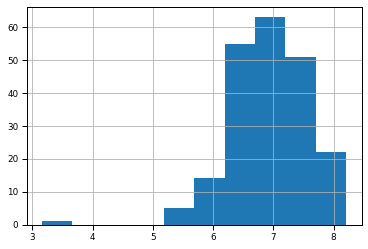

In [109]:
animeList[(animeList['studio'] == 'Toei Animation') & (animeList['genres'].str.contains('Action'))].score.hist()

In [110]:
animeList[(animeList['studio'] == 'Toei Animation') & (animeList['genres'].str.contains('Action'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,211.000000,211.000000,211.000000,211.000000,211.0,211.000000,211.000000,211.000000,211.000000
mean,6.939100,40866.687204,337.398104,20.018957,450.0,4.069315,-2.636036,0.690095,0.435313
std,0.647281,83039.934509,2130.710647,32.221253,0.0,0.725042,0.467142,0.087946,0.179362
min,3.160000,445.000000,1.000000,1.000000,450.0,2.648360,-3.773036,0.176630,0.083795
25%,6.510000,2909.000000,6.000000,1.000000,450.0,3.463742,-2.981662,0.631793,0.285505
50%,6.990000,11514.000000,25.000000,1.000000,450.0,4.061226,-2.585726,0.697011,0.433312
75%,7.365000,43691.000000,93.500000,39.000000,450.0,4.640391,-2.341922,0.747962,0.576586
max,8.210000,798830.000000,29369.000000,291.000000,450.0,5.902454,-1.434565,0.862772,0.888796


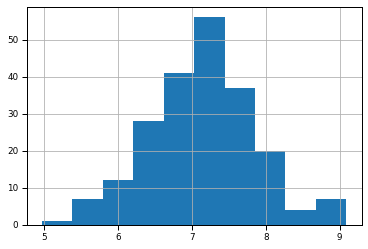

In [111]:
animeList[(animeList['studio'] == 'Sunrise') & (animeList['genres'].str.contains('Action'))].score.hist()

In [112]:
animeList[(animeList['studio'] == 'Sunrise') & (animeList['genres'].str.contains('Action'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,213.000000,2.130000e+02,213.000000,213.000000,213.0,213.000000,213.000000,213.000000,213.000000
mean,7.147183,5.776915e+04,1501.751174,15.713615,420.0,4.131776,-2.593568,0.718367,0.450764
std,0.732409,1.633134e+05,8575.686369,23.716041,0.0,0.713876,0.498636,0.099512,0.176599
min,4.970000,5.670000e+02,1.000000,1.000000,420.0,2.753583,-3.698362,0.422554,0.109826
25%,6.650000,3.669000e+03,5.000000,1.000000,420.0,3.564548,-2.948902,0.650815,0.310443
50%,7.180000,9.859000e+03,27.000000,3.000000,420.0,3.993833,-2.605137,0.722826,0.416640
75%,7.640000,4.844200e+04,159.000000,25.000000,420.0,4.685222,-2.289325,0.785326,0.587676
max,9.090000,1.429301e+06,83885.000000,201.000000,420.0,6.155124,-1.185547,0.982337,0.951302


In [113]:
animeList[(animeList['studio'] == 'Toei Animation') & (animeList['genres'].str.contains('Action'))].describe() - animeList[(animeList['studio'] == 'Sunrise') & (animeList['genres'].str.contains('Action'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,-2.000000,-2.000000,-2.000000
mean,-0.208084,-16902.463031,-1164.353069,4.305342,30.0,-0.062461,-0.042468,-0.028272,-0.015452
std,-0.085128,-80273.463104,-6444.975723,8.505212,0.0,0.011166,-0.031495,-0.011566,0.002762
min,-1.810000,-122.000000,0.000000,0.000000,30.0,-0.105223,-0.074675,-0.245924,-0.026030
25%,-0.140000,-760.000000,1.000000,0.000000,30.0,-0.100806,-0.032760,-0.019022,-0.024937
50%,-0.190000,1655.000000,-2.000000,-2.000000,30.0,0.067393,0.019411,-0.025815,0.016672
75%,-0.275000,-4751.000000,-65.500000,14.000000,30.0,-0.044831,-0.052597,-0.037364,-0.011090
max,-0.880000,-630471.000000,-54516.000000,90.000000,30.0,-0.252669,-0.249019,-0.119565,-0.062506


In [114]:
animeList[(animeList['studio'] == 'Toei Animation') & (animeList['genres'].str.contains('Action'))].describe()/animeList[(animeList['studio'] == 'Sunrise') & (animeList['genres'].str.contains('Action'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,0.990610,0.990610,0.990610,0.990610,0.990610,0.990610,0.990610,0.990610,0.990610
mean,0.970886,0.707414,0.224670,1.273988,1.071429,0.984883,1.016374,0.960644,0.965721
std,0.883770,0.508470,0.248459,1.358627,NaN,1.015642,0.936838,0.883770,1.015642
min,0.635815,0.784832,1.000000,1.000000,1.071429,0.961787,1.020191,0.418006,0.762986
25%,0.978947,0.792859,1.200000,1.000000,1.071429,0.971720,1.011109,0.970772,0.919672
50%,0.973538,1.167867,0.925926,0.333333,1.071429,1.016874,0.992549,0.964286,1.040015
75%,0.964005,0.901924,0.588050,1.560000,1.071429,0.990431,1.022975,0.952422,0.981128
max,0.903190,0.558896,0.350110,1.447761,1.071429,0.958950,1.210045,0.878285,0.934295


Para animes de Ação, a **Sunrise** possui vantagem de score em todos os pontos, além de possuir comunidade ligeiramente maior no 1° e 3° quartil (20% e 9% respectivamente)

In [115]:
# Toei e Sunrise
stats.mannwhitneyu(animeList[(animeList['studio'] == 'Toei Animation') & (animeList['genres'].str.contains('Comedy'))].score,animeList[(animeList['studio'] == 'Sunrise') & (animeList['genres'].str.contains('Comedy'))].score)

MannwhitneyuResult(statistic=9577.5, pvalue=0.01000091325322968)

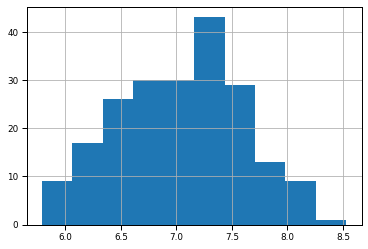

In [116]:
animeList[(animeList['studio'] == 'Toei Animation') & (animeList['genres'].str.contains('Comedy'))].score.hist()

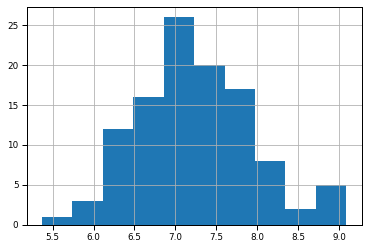

In [117]:
animeList[(animeList['studio'] == 'Sunrise') & (animeList['genres'].str.contains('Comedy'))].score.hist()

In [118]:
animeList[(animeList['studio'] == 'Toei Animation') & (animeList['genres'].str.contains('Comedy'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,207.000000,207.000000,207.000000,207.000000,207.0,207.000000,207.000000,207.000000,207.000000
mean,7.028213,48044.198068,464.386473,25.560386,450.0,4.159349,-2.677755,0.702203,0.457585
std,0.570679,95848.705366,2383.062133,44.781725,0.0,0.738207,0.487868,0.077538,0.182618
min,5.790000,476.000000,1.000000,1.000000,450.0,2.677607,-3.773036,0.533967,0.091030
25%,6.600000,3706.500000,6.500000,1.000000,450.0,3.568402,-3.055436,0.644022,0.311396
50%,7.080000,16780.000000,29.000000,1.000000,450.0,4.224792,-2.683347,0.709239,0.473775
75%,7.435000,52020.000000,104.500000,46.500000,450.0,4.715748,-2.340998,0.757473,0.595228
max,8.530000,798830.000000,29369.000000,296.000000,450.0,5.902454,-1.434565,0.906250,0.888796


In [119]:
animeList[(animeList['studio'] == 'Sunrise') & (animeList['genres'].str.contains('Comedy'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,110.000000,1.100000e+02,110.000000,110.000000,110.0,110.000000,110.000000,110.000000,110.000000
mean,7.241909,5.580130e+04,1406.700000,21.318182,420.0,4.118718,-2.591170,0.731238,0.447534
std,0.724666,1.456382e+05,7005.718624,44.314748,0.0,0.692380,0.511938,0.098460,0.171282
min,5.370000,5.660000e+02,1.000000,1.000000,420.0,2.752816,-3.698362,0.476902,0.109636
25%,6.717500,3.977750e+03,5.000000,1.000000,420.0,3.599637,-2.845972,0.659986,0.319123
50%,7.195000,9.040500e+03,25.500000,5.000000,420.0,3.954918,-2.606396,0.724864,0.407013
75%,7.715000,4.071800e+04,117.500000,26.000000,420.0,4.607090,-2.359595,0.795516,0.568348
max,9.090000,1.109351e+06,56308.000000,358.000000,420.0,6.045069,-1.185547,0.982337,0.924077


In [120]:
animeList[(animeList['studio'] == 'Toei Animation') & (animeList['genres'].str.contains('Comedy'))].describe() - animeList[(animeList['studio'] == 'Sunrise') & (animeList['genres'].str.contains('Comedy'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,97.000000,97.000000,97.000000,97.000000,97.0,97.000000,97.000000,97.000000,97.000000
mean,-0.213697,-7757.101932,-942.313527,4.242205,30.0,0.040631,-0.086585,-0.029035,0.010051
std,-0.153987,-49789.494475,-4622.656491,0.466977,0.0,0.045827,-0.024070,-0.020922,0.011337
min,0.420000,-90.000000,0.000000,0.000000,30.0,-0.075209,-0.074675,0.057065,-0.018605
25%,-0.117500,-271.250000,1.500000,0.000000,30.0,-0.031236,-0.209464,-0.015965,-0.007727
50%,-0.115000,7739.500000,3.500000,-4.000000,30.0,0.269874,-0.076951,-0.015625,0.066762
75%,-0.280000,11302.000000,-13.000000,20.500000,30.0,0.108658,0.018598,-0.038043,0.026880
max,-0.560000,-310521.000000,-26939.000000,-62.000000,30.0,-0.142615,-0.249019,-0.076087,-0.035280


In [121]:
animeList[(animeList['studio'] == 'Sunrise') & (animeList['genres'].str.contains('Comedy'))].describe()/animeList[(animeList['studio'] == 'Toei Animation') & (animeList['genres'].str.contains('Comedy'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,0.531401,0.531401,0.531401,0.531401,0.531401,0.531401,0.531401,0.531401,0.531401
mean,1.030406,1.161458,3.029158,0.834032,0.933333,0.990231,0.967665,1.041348,0.978034
std,1.269832,1.519459,2.939797,0.989572,NaN,0.937921,1.049337,1.269832,0.937921
min,0.927461,1.189076,1.000000,1.000000,0.933333,1.028088,0.980208,0.893130,1.204386
25%,1.017803,1.073182,0.769231,1.000000,0.933333,1.008753,0.931445,1.024789,1.024814
50%,1.016243,0.538766,0.879310,5.000000,0.933333,0.936121,0.971323,1.022031,0.859086
75%,1.037660,0.782737,1.124402,0.559140,0.933333,0.976958,1.007944,1.050224,0.954841
max,1.065651,1.388720,1.917260,1.209459,0.933333,1.024162,0.826415,1.083958,1.039694


Para animes de comédia, a **Sunrise** possui grande vantagem de score em quase todos os pontos, porém sua comunidade é menor, tendo em vista a menor quantidade de membros para 2° e o 3° quartil (46% e 21% respectivamente)

In [122]:
# Toei e Sunrise
stats.mannwhitneyu(animeList[(animeList['studio'] == 'Toei Animation') & (animeList['genres'].str.contains('Shounen'))].score,animeList[(animeList['studio'] == 'Sunrise') & (animeList['genres'].str.contains('Shounen'))].score)

MannwhitneyuResult(statistic=6876.5, pvalue=0.0014171902820669755)

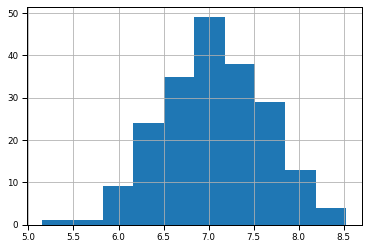

In [123]:
animeList[(animeList['studio'] == 'Toei Animation') & (animeList['genres'].str.contains('Shounen'))].score.hist()

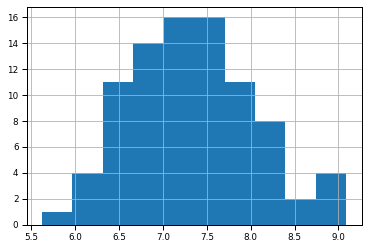

In [124]:
animeList[(animeList['studio'] == 'Sunrise') & (animeList['genres'].str.contains('Shounen'))].score.hist()

In [125]:
animeList[(animeList['studio'] == 'Toei Animation') & (animeList['genres'].str.contains('Shounen'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,203.00000,203.000000,203.000000,203.000000,203.0,203.000000,203.000000,203.000000,203.000000
mean,7.05936,46338.541872,429.610837,22.837438,450.0,4.157749,-2.680377,0.706435,0.457189
std,0.55585,92922.868427,2343.366547,41.480261,0.0,0.717047,0.474096,0.075523,0.177384
min,5.15000,445.000000,1.000000,1.000000,450.0,2.648360,-3.773036,0.447011,0.083795
25%,6.68000,4774.000000,7.500000,1.000000,450.0,3.678553,-3.060097,0.654891,0.338645
50%,7.07000,16063.000000,25.000000,1.000000,450.0,4.205827,-2.652246,0.707880,0.469083
75%,7.40500,49270.500000,77.000000,34.500000,450.0,4.692568,-2.348845,0.753397,0.589494
max,8.53000,798830.000000,29369.000000,291.000000,450.0,5.902454,-1.434565,0.906250,0.888796


In [126]:
animeList[(animeList['studio'] == 'Sunrise') & (animeList['genres'].str.contains('Shounen'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,87.000000,87.000000,87.000000,87.000000,87.0,87.000000,87.000000,87.000000,87.000000
mean,7.324828,41594.229885,922.298851,29.781609,420.0,3.920251,-2.439627,0.742504,0.398437
std,0.701397,102917.694522,5048.510858,49.100615,0.0,0.743797,0.440982,0.095299,0.184001
min,5.620000,460.000000,1.000000,1.000000,420.0,2.662758,-3.698362,0.510870,0.087357
25%,6.830000,2016.500000,6.500000,1.000000,420.0,3.304574,-2.667400,0.675272,0.246130
50%,7.310000,5003.000000,19.000000,13.000000,420.0,3.699231,-2.424119,0.740489,0.343761
75%,7.765000,29221.000000,94.000000,47.500000,420.0,4.465687,-2.202094,0.802310,0.533367
max,9.090000,679586.000000,44330.000000,358.000000,420.0,5.832244,-1.185547,0.982337,0.871428


In [127]:
animeList[(animeList['studio'] == 'Toei Animation') & (animeList['genres'].str.contains('Shounen'))].describe() - animeList[(animeList['studio'] == 'Sunrise') & (animeList['genres'].str.contains('Shounen'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,116.000000,116.000000,116.000000,116.000000,116.0,116.000000,116.000000,116.000000,116.000000
mean,-0.265468,4744.311987,-492.688013,-6.944171,30.0,0.237498,-0.240750,-0.036069,0.058752
std,-0.145547,-9994.826094,-2705.144311,-7.620354,0.0,-0.026750,0.033114,-0.019775,-0.006617
min,-0.470000,-15.000000,0.000000,0.000000,30.0,-0.014398,-0.074675,-0.063859,-0.003562
25%,-0.150000,2757.500000,1.000000,0.000000,30.0,0.373979,-0.392697,-0.020380,0.092515
50%,-0.240000,11060.000000,6.000000,-12.000000,30.0,0.506596,-0.228127,-0.032609,0.125322
75%,-0.360000,20049.500000,-17.000000,-13.000000,30.0,0.226882,-0.146751,-0.048913,0.056126
max,-0.560000,119244.000000,-14961.000000,-67.000000,30.0,0.070210,-0.249019,-0.076087,0.017369


In [128]:
animeList[(animeList['studio'] == 'Sunrise') & (animeList['genres'].str.contains('Shounen'))].describe()/animeList[(animeList['studio'] == 'Toei Animation') & (animeList['genres'].str.contains('Shounen'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571
mean,1.037605,0.897616,2.146824,1.304070,0.933333,0.942878,0.910181,1.051058,0.871492
std,1.261846,1.107560,2.154384,1.183710,NaN,1.037306,0.930154,1.261846,1.037306
min,1.091262,1.033708,1.000000,1.000000,0.933333,1.005437,0.980208,1.142857,1.042505
25%,1.022455,0.422392,0.866667,1.000000,0.933333,0.898335,0.871672,1.031120,0.726808
50%,1.033946,0.311461,0.760000,13.000000,0.933333,0.879549,0.913987,1.046065,0.732836
75%,1.048616,0.593073,1.220779,1.376812,0.933333,0.951651,0.937522,1.064923,0.904789
max,1.065651,0.850727,1.509415,1.230241,0.933333,0.988105,0.826415,1.083958,0.980458


Para animes de Shounen, a **Sunrise** possui vantagem de score em todos os quartis, porém, novamente sua comunidade é menor, tendo em vista a menor quantidade de membros para 1°, 2° e o 3° quartil (57%, 68% e 40%)

Desta forma temos que
- De forma geral, Sunrise tem maior "qualidade" entre os animes
- Animes da **Toei Animation** alcança um publico maior
- Animes de ação da **Sunrise** são mais propensos a sucesso, tanto em qualidade quanto em alcance da comunidade
- Dados não são identicos, tendo em vista que nenhum teste normal possuiu p-value alto

### Analise Toei Animation e Madhouse

In [129]:
# Toei e Madhouse
stats.mannwhitneyu(animeList[(animeList['studio'] == 'Toei Animation') & (animeList['genres'].str.contains('Action'))].score,animeList[(animeList['studio'] == 'Madhouse') & (animeList['genres'].str.contains('Action'))].score)

MannwhitneyuResult(statistic=10953.5, pvalue=0.3830573191700923)

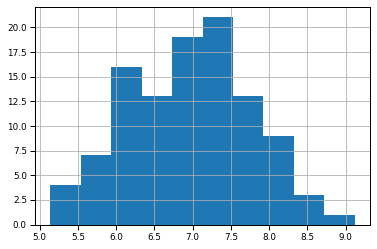

In [130]:
animeList[(animeList['studio'] == 'Madhouse') & (animeList['genres'].str.contains('Action'))].score.hist()

In [131]:
animeList[(animeList['studio'] == 'Madhouse') & (animeList['genres'].str.contains('Action'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,106.000000,1.060000e+02,106.000000,106.000000,106.0,106.000000,106.000000,106.000000,106.000000
mean,6.976415,1.497023e+05,3046.745283,13.877358,224.0,4.497865,-2.513885,0.695165,0.541328
std,0.808671,3.003889e+05,13332.890363,20.869528,0.0,0.823763,0.473562,0.109874,0.203783
min,5.140000,5.610000e+02,1.000000,1.000000,224.0,2.748963,-3.480007,0.445652,0.108683
25%,6.335000,7.403750e+03,12.000000,1.000000,224.0,3.869329,-2.830743,0.608016,0.385840
50%,7.010000,2.743100e+04,78.000000,12.000000,224.0,4.438019,-2.585885,0.699728,0.526523
75%,7.490000,1.248842e+05,604.500000,13.000000,224.0,5.096489,-2.239722,0.764946,0.689416
max,9.120000,1.838940e+06,124303.000000,148.000000,224.0,6.264568,-1.047107,0.986413,0.978376


In [132]:
animeList[(animeList['studio'] == 'Toei Animation') & (animeList['genres'].str.contains('Action'))].describe() - animeList[(animeList['studio'] == 'Madhouse') & (animeList['genres'].str.contains('Action'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,105.000000,1.050000e+02,105.000000,105.000000,105.0,105.000000,105.000000,105.000000,105.000000
mean,-0.037316,-1.088356e+05,-2709.347179,6.141599,226.0,-0.428550,-0.122151,-0.005070,-0.106015
std,-0.161390,-2.173489e+05,-11202.179716,11.351725,0.0,-0.098721,-0.006420,-0.021928,-0.024422
min,-1.980000,-1.160000e+02,0.000000,0.000000,226.0,-0.100603,-0.293029,-0.269022,-0.024887
25%,0.175000,-4.494750e+03,-6.000000,0.000000,226.0,-0.405586,-0.150919,0.023777,-0.100334
50%,-0.020000,-1.591700e+04,-53.000000,-11.000000,226.0,-0.376793,0.000158,-0.002717,-0.093211
75%,-0.125000,-8.119325e+04,-511.000000,26.000000,226.0,-0.456098,-0.102201,-0.016984,-0.112830
max,-0.910000,-1.040110e+06,-94934.000000,143.000000,226.0,-0.362113,-0.387458,-0.123641,-0.089580


In [133]:
animeList[(animeList['studio'] == 'Toei Animation') & (animeList['genres'].str.contains('Action'))].describe()/animeList[(animeList['studio'] == 'Madhouse') & (animeList['genres'].str.contains('Action'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,1.990566,1.990566,1.990566,1.990566,1.990566,1.990566,1.990566,1.990566,1.990566
mean,0.994651,0.272986,0.110741,1.442563,2.008929,0.904721,1.048591,0.992707,0.804157
std,0.800426,0.276441,0.159809,1.543938,NaN,0.880159,0.986443,0.800426,0.880159
min,0.614786,0.793226,1.000000,1.000000,2.008929,0.963403,1.084204,0.396341,0.771010
25%,1.027624,0.392909,0.500000,1.000000,2.008929,0.895179,1.053314,1.039106,0.739958
50%,0.997147,0.419744,0.320513,0.083333,2.008929,0.915099,0.999939,0.996117,0.822968
75%,0.983311,0.349852,0.154673,3.000000,2.008929,0.910507,1.045631,0.977798,0.836340
max,0.900219,0.434397,0.236269,1.966216,2.008929,0.942197,1.370028,0.874656,0.908440


Animes de ação da **Toei Animation** normalmente possui score ligeiramente menor em relação a **Madhouse**, e comunidade menor em todos os quartis (60%, 58% e 65%)

In [134]:
# Toei e Madhouse
stats.mannwhitneyu(animeList[(animeList['studio'] == 'Toei Animation') & (animeList['genres'].str.contains('Comedy'))].score,animeList[(animeList['studio'] == 'Madhouse') & (animeList['genres'].str.contains('Comedy'))].score)

MannwhitneyuResult(statistic=11494.0, pvalue=0.130671211987548)

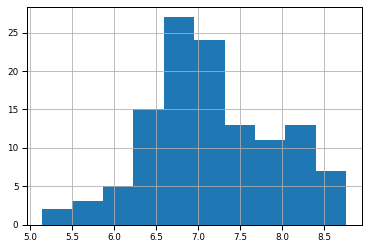

In [135]:
animeList[(animeList['studio'] == 'Madhouse') & (animeList['genres'].str.contains('Comedy'))].score.hist()

In [136]:
animeList[(animeList['studio'] == 'Madhouse') & (animeList['genres'].str.contains('Comedy'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,120.000000,1.200000e+02,120.00000,120.000000,120.0,120.000000,120.000000,120.000000,120.000000
mean,7.148667,9.351693e+04,1772.65000,18.558333,224.0,4.328040,-2.543591,0.718569,0.499316
std,0.758378,2.355909e+05,6527.95881,24.889941,0.0,0.756959,0.508059,0.103041,0.187257
min,5.140000,5.590000e+02,1.00000,1.000000,224.0,2.747412,-3.679973,0.445652,0.108299
25%,6.665000,5.533500e+03,8.00000,1.000000,224.0,3.742985,-2.880780,0.652853,0.354585
50%,7.005000,1.831800e+04,46.50000,12.000000,224.0,4.262878,-2.630897,0.699049,0.483196
75%,7.697500,8.247950e+04,345.00000,25.000000,224.0,4.916202,-2.236058,0.793139,0.644816
max,8.760000,1.838940e+06,49327.00000,124.000000,224.0,6.264568,-1.320661,0.937500,0.978376


In [137]:
animeList[(animeList['studio'] == 'Toei Animation') & (animeList['genres'].str.contains('Comedy'))].describe() - animeList[(animeList['studio'] == 'Madhouse') & (animeList['genres'].str.contains('Comedy'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,87.000000,8.700000e+01,87.000000,87.000000,87.0,87.000000,87.000000,87.000000,87.000000
mean,-0.120454,-4.547274e+04,-1308.263527,7.002053,226.0,-0.168690,-0.134164,-0.016366,-0.041731
std,-0.187700,-1.397422e+05,-4144.896677,19.891784,0.0,-0.018752,-0.020191,-0.025503,-0.004639
min,0.650000,-8.300000e+01,0.000000,0.000000,226.0,-0.069805,-0.093064,0.088315,-0.017268
25%,-0.065000,-1.827000e+03,-1.500000,0.000000,226.0,-0.174583,-0.174656,-0.008832,-0.043189
50%,0.075000,-1.538000e+03,-17.500000,-11.000000,226.0,-0.038086,-0.052450,0.010190,-0.009422
75%,-0.262500,-3.045950e+04,-240.500000,21.500000,226.0,-0.200454,-0.104940,-0.035666,-0.049588
max,-0.230000,-1.040110e+06,-19958.000000,172.000000,226.0,-0.362113,-0.113904,-0.031250,-0.089580


In [138]:
animeList[(animeList['studio'] == 'Toei Animation') & (animeList['genres'].str.contains('Comedy'))].describe()/animeList[(animeList['studio'] == 'Madhouse') & (animeList['genres'].str.contains('Comedy'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,1.725000,1.725000,1.725000,1.725000,1.725000,1.725000,1.725000,1.725000,1.725000
mean,0.983150,0.513749,0.261973,1.377300,2.008929,0.961024,1.052746,0.977224,0.916424
std,0.752498,0.406844,0.365055,1.799190,NaN,0.975228,0.960259,0.752498,0.975228
min,1.126459,0.851521,1.000000,1.000000,2.008929,0.974593,1.025289,1.198171,0.840549
25%,0.990248,0.669829,0.812500,1.000000,2.008929,0.953357,1.060628,0.986472,0.878200
50%,1.010707,0.916039,0.623656,0.083333,2.008929,0.991066,1.019936,1.014577,0.980501
75%,0.965898,0.630702,0.302899,1.860000,2.008929,0.959226,1.046931,0.955032,0.923097
max,0.973744,0.434397,0.595394,2.387097,2.008929,0.942197,1.086248,0.966667,0.908440


Os animes da **Toei Animation** de comédia possuem scores ligeiramente menores em relação a **Madhouse**, porém, em comunidade é menor em seus quartis (33%, 8%, 36%)

In [139]:
# Toei e Madhouse
stats.mannwhitneyu(animeList[(animeList['studio'] == 'Toei Animation') & (animeList['genres'].str.contains('Shounen'))].score,animeList[(animeList['studio'] == 'Madhouse') & (animeList['genres'].str.contains('Shounen'))].score)

MannwhitneyuResult(statistic=5537.0, pvalue=0.24530008373395784)

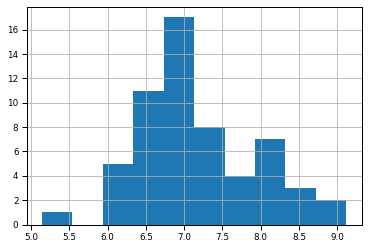

In [140]:
animeList[(animeList['studio'] == 'Madhouse') & (animeList['genres'].str.contains('Shounen'))].score.hist()

In [141]:
animeList[(animeList['studio'] == 'Madhouse') & (animeList['genres'].str.contains('Shounen'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,58.000000,5.800000e+01,58.000000,58.000000,58.0,58.000000,58.000000,58.000000,58.000000
mean,7.195690,1.453054e+05,5371.689655,19.120690,224.0,4.503559,-2.456808,0.724958,0.542736
std,0.785487,3.678910e+05,23080.608440,25.310062,0.0,0.760258,0.481024,0.106724,0.188073
min,5.140000,7.120000e+02,1.000000,1.000000,224.0,2.852480,-3.350732,0.445652,0.134291
25%,6.692500,1.032875e+04,17.500000,1.000000,224.0,4.013043,-2.712940,0.656590,0.421392
50%,7.050000,3.627800e+04,92.500000,12.500000,224.0,4.559628,-2.558166,0.705163,0.556607
75%,7.600000,9.116025e+04,460.250000,26.000000,224.0,4.959806,-2.235192,0.779891,0.655603
max,9.120000,2.248940e+06,126576.000000,148.000000,224.0,6.351978,-1.047107,0.986413,1.000000


In [142]:
animeList[(animeList['studio'] == 'Toei Animation') & (animeList['genres'].str.contains('Shounen'))].describe() - animeList[(animeList['studio'] == 'Madhouse') & (animeList['genres'].str.contains('Shounen'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,145.000000,1.450000e+02,145.000000,145.000000,145.0,145.000000,145.000000,145.000000,145.000000
mean,-0.136330,-9.896689e+04,-4942.078818,3.716749,226.0,-0.345810,-0.223568,-0.018523,-0.085547
std,-0.229637,-2.749681e+05,-20737.241893,16.170200,0.0,-0.043211,-0.006928,-0.031201,-0.010690
min,0.010000,-2.670000e+02,0.000000,0.000000,226.0,-0.204120,-0.422304,0.001359,-0.050495
25%,-0.012500,-5.554750e+03,-10.000000,0.000000,226.0,-0.334491,-0.347157,-0.001698,-0.082747
50%,0.020000,-2.021500e+04,-67.500000,-11.500000,226.0,-0.353801,-0.094081,0.002717,-0.087524
75%,-0.195000,-4.188975e+04,-383.250000,8.500000,226.0,-0.267237,-0.113653,-0.026495,-0.066109
max,-0.590000,-1.450110e+06,-97207.000000,143.000000,226.0,-0.449524,-0.387458,-0.080163,-0.111204


In [143]:
animeList[(animeList['studio'] == 'Toei Animation') & (animeList['genres'].str.contains('Shounen'))].describe()/animeList[(animeList['studio'] == 'Madhouse') & (animeList['genres'].str.contains('Shounen'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
mean,0.981054,0.318904,0.079977,1.194384,2.008929,0.923214,1.091000,0.974449,0.842378
std,0.707650,0.252583,0.101530,1.638884,NaN,0.943163,0.985596,0.707650,0.943163
min,1.001946,0.625000,1.000000,1.000000,2.008929,0.928441,1.126033,1.003049,0.623984
25%,0.998132,0.462205,0.428571,1.000000,2.008929,0.916649,1.127963,0.997413,0.803635
50%,1.002837,0.442775,0.270270,0.080000,2.008929,0.922406,1.036777,1.003854,0.842755
75%,0.974342,0.540482,0.167300,1.326923,2.008929,0.946119,1.050847,0.966028,0.899162
max,0.935307,0.355203,0.232027,1.966216,2.008929,0.929231,1.370028,0.918733,0.888796


Para animes do gênero de Shounen, **Toei Animation** possui scores ligeiramente menores, além de uma comunidade menor em todos os quartis (53%, 55%, 45%)

Temos então na comparação da **Toei Animation** com a **Madhouse** que:
- Animes da **Toei Animation** geralmente possuem score ligeiramente menor
- O alcance dos animes da **Madhouse**,em sua maioria, é maior, tendo em vista uma quantidade de membros maior.
- Os dados não são identicos por possuir p-value muito baixo

### Analise Sunrise e Madhouse

In [144]:
# Sunrise e Madhouse
stats.mannwhitneyu(animeList[(animeList['studio'] == 'Sunrise') & (animeList['genres'].str.contains('Action'))].score,animeList[(animeList['studio'] == 'Madhouse') & (animeList['genres'].str.contains('Action'))].score)

MannwhitneyuResult(statistic=9968.0, pvalue=0.04439178217974991)

In [145]:
animeList[(animeList['studio'] == 'Sunrise') & (animeList['genres'].str.contains('Action'))].describe()-animeList[(animeList['studio'] == 'Madhouse') & (animeList['genres'].str.contains('Action'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,107.000000,107.000000,107.000000,107.000000,107.0,107.000000,107.000000,107.000000,107.000000
mean,0.170768,-91933.142218,-1544.994109,1.836257,196.0,-0.366089,-0.079684,0.023202,-0.090563
std,-0.076262,-137075.480643,-4757.203994,2.846513,0.0,-0.109887,0.025074,-0.010362,-0.027184
min,-0.170000,6.000000,0.000000,0.000000,196.0,0.004620,-0.218355,-0.023098,0.001143
25%,0.315000,-3734.750000,-7.000000,0.000000,196.0,-0.304781,-0.118159,0.042799,-0.075397
50%,0.170000,-17572.000000,-51.000000,-9.000000,196.0,-0.444186,-0.019253,0.023098,-0.109883
75%,0.150000,-76442.250000,-445.500000,12.000000,196.0,-0.411267,-0.049604,0.020380,-0.101740
max,-0.030000,-409639.000000,-40418.000000,53.000000,196.0,-0.109444,-0.138440,-0.004076,-0.027074


In [146]:
animeList[(animeList['studio'] == 'Sunrise') & (animeList['genres'].str.contains('Action'))].describe()/animeList[(animeList['studio'] == 'Madhouse') & (animeList['genres'].str.contains('Action'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,2.009434,2.009434,2.009434,2.009434,2.009434,2.009434,2.009434,2.009434,2.009434
mean,1.024478,0.385894,0.492903,1.132320,1.875000,0.918608,1.031697,1.033376,0.832701
std,0.905695,0.543673,0.643198,1.136396,NaN,0.866603,1.052948,0.905695,0.866603
min,0.966926,1.010695,1.000000,1.000000,1.875000,1.001681,1.062745,0.948171,1.010516
25%,1.049724,0.495560,0.416667,1.000000,1.875000,0.921232,1.041741,1.070391,0.804590
50%,1.024251,0.359411,0.346154,0.250000,1.875000,0.899913,1.007445,1.033010,0.791304
75%,1.020027,0.387895,0.263027,1.923077,1.875000,0.919304,1.022147,1.026643,0.852426
max,0.996711,0.777242,0.674843,1.358108,1.875000,0.982530,1.132212,0.995868,0.972327


Em relação aos animes de Ação, a **Sunrise** possui scores ligeiramente maiores aos da **Madhouse**, porém, sua comunidade é bem menor em relação aos da 'Madhouse', tendo em seus quartis uma comunidade (40%, 64%, 61%) maior.

In [147]:
# Sunrise e Madhouse
stats.mannwhitneyu(animeList[(animeList['studio'] == 'Sunrise') & (animeList['genres'].str.contains('Comedy'))].score,animeList[(animeList['studio'] == 'Madhouse') & (animeList['genres'].str.contains('Comedy'))].score)

MannwhitneyuResult(statistic=6119.0, pvalue=0.1702326090658448)

In [148]:
animeList[(animeList['studio'] == 'Sunrise') & (animeList['genres'].str.contains('Comedy'))].describe()-animeList[(animeList['studio'] == 'Madhouse') & (animeList['genres'].str.contains('Comedy'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,-10.000000,-10.000000,-10.000000,-10.000000,-10.0,-10.000000,-10.000000,-10.000000,-10.000000
mean,0.093242,-37715.633333,-365.950000,2.759848,196.0,-0.209321,-0.047579,0.012669,-0.051782
std,-0.033713,-89952.738511,477.759814,19.424807,0.0,-0.064578,0.003879,-0.004581,-0.015975
min,0.230000,7.000000,0.000000,0.000000,196.0,0.005405,-0.018389,0.031250,0.001337
25%,0.052500,-1555.750000,-3.000000,0.000000,196.0,-0.143348,0.034808,0.007133,-0.035461
50%,0.190000,-9277.500000,-21.000000,-7.000000,196.0,-0.307960,0.024501,0.025815,-0.076183
75%,0.017500,-41761.500000,-227.500000,1.000000,196.0,-0.309112,-0.123538,0.002378,-0.076469
max,0.330000,-729589.000000,6981.000000,234.000000,196.0,-0.219499,0.135114,0.044837,-0.054300


In [149]:
animeList[(animeList['studio'] == 'Sunrise') & (animeList['genres'].str.contains('Comedy'))].describe()/animeList[(animeList['studio'] == 'Madhouse') & (animeList['genres'].str.contains('Comedy'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,0.916667,0.916667,0.916667,0.916667,0.916667,0.916667,0.916667,0.916667,0.916667
mean,1.013043,0.596697,0.793558,1.148712,1.875000,0.951636,1.018705,1.017631,0.896294
std,0.955546,0.618183,1.073187,1.780428,NaN,0.914687,1.007635,0.955546,0.914687
min,1.044747,1.012522,1.000000,1.000000,1.875000,1.001967,1.004997,1.070122,1.012345
25%,1.007877,0.718849,0.625000,1.000000,1.875000,0.961702,0.987917,1.010926,0.899992
50%,1.027123,0.493531,0.548387,0.416667,1.875000,0.927758,0.990687,1.036929,0.842335
75%,1.002273,0.493674,0.340580,1.040000,1.875000,0.937124,1.055248,1.002998,0.881410
max,1.037671,0.603256,1.141525,2.887097,1.875000,0.964962,0.897692,1.047826,0.944500


Em relação a Comédia, novamente, animes da **Sunrise** possuem score ligeiramente maior em relação a **Madhouse**, e uma comunidade menor em seus quartis (28%, 50%, 50%)

In [150]:
# Sunrise e Madhouse
stats.mannwhitneyu(animeList[(animeList['studio'] == 'Sunrise') & (animeList['genres'].str.contains('Shounen'))].score,animeList[(animeList['studio'] == 'Madhouse') & (animeList['genres'].str.contains('Shounen'))].score)

MannwhitneyuResult(statistic=2207.0, pvalue=0.10143902009730582)

In [151]:
animeList[(animeList['studio'] == 'Sunrise') & (animeList['genres'].str.contains('Shounen'))].describe()-animeList[(animeList['studio'] == 'Madhouse') & (animeList['genres'].str.contains('Shounen'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,29.000000,2.900000e+01,29.000000,29.000000,29.0,29.000000,29.000000,29.000000,29.000000
mean,0.129138,-1.037112e+05,-4449.390805,10.660920,196.0,-0.583308,0.017182,0.017546,-0.144299
std,-0.084090,-2.649733e+05,-18032.097582,23.790553,0.0,-0.016461,-0.040042,-0.011425,-0.004072
min,0.480000,-2.520000e+02,0.000000,0.000000,196.0,-0.189722,-0.347629,0.065217,-0.046934
25%,0.137500,-8.312250e+03,-11.000000,0.000000,196.0,-0.708470,0.045540,0.018682,-0.175262
50%,0.260000,-3.127500e+04,-73.500000,0.500000,196.0,-0.860397,0.134047,0.035326,-0.212846
75%,0.165000,-6.193925e+04,-366.250000,21.500000,196.0,-0.494119,0.033097,0.022418,-0.122236
max,-0.030000,-1.569354e+06,-82246.000000,210.000000,196.0,-0.519733,-0.138440,-0.004076,-0.128572


In [152]:
animeList[(animeList['studio'] == 'Sunrise') & (animeList['genres'].str.contains('Shounen'))].describe()/animeList[(animeList['studio'] == 'Madhouse') & (animeList['genres'].str.contains('Shounen'))].describe()

,score,members,favorites,episodes,studioCode,members_log,favorite_per_member,scoreNorm,membersLogNorm
count,1.500000,1.500000,1.500000,1.500000,1.500,1.500000,1.500000,1.500000,1.500000
mean,1.017947,0.286254,0.171696,1.557559,1.875,0.870478,0.993006,1.024203,0.734126
std,0.892945,0.279751,0.218734,1.939964,NaN,0.978348,0.916756,0.892945,0.978348
min,1.093385,0.646067,1.000000,1.000000,1.875,0.933489,1.103747,1.146341,0.650507
25%,1.020545,0.195232,0.371429,1.000000,1.875,0.823458,0.983214,1.028453,0.584088
50%,1.036879,0.137907,0.205405,1.040000,1.875,0.811301,0.947600,1.050096,0.617601
75%,1.021711,0.320545,0.204237,1.826923,1.875,0.900375,0.985193,1.028746,0.813552
max,0.996711,0.302181,0.350224,2.418919,1.875,0.918178,1.132212,0.995868,0.871428


Para animes de Shounen, temos novamente a **Sunrise** como animes de maior score, e a **Madhouse** com a comunidade muito maior em seus quartis (80%, 86%, 67%)
Realizando uma pequena pesquisa a **Madhouse** realizou a animação de animes muito famosos como:
- Hunter X Hunter
- Overlord
- One Punch Man
- No game no life

Talvez desta forma as pessoas venham a se interessar para ir mais a fundo em produções de gênero parecido deste estúdio, resultando sua grande popularidade em animes distintos.

## Score Plot dos estúdios analisados

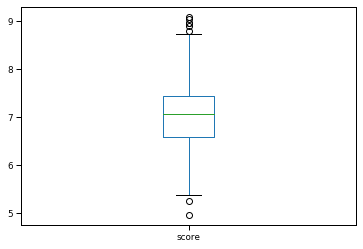

In [153]:
animeList[(animeList['studio'] == 'Sunrise')].score.plot.box()

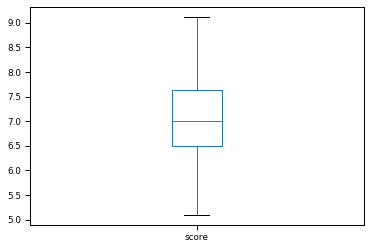

In [154]:
animeList[(animeList['studio'] == 'Madhouse')].score.plot.box()

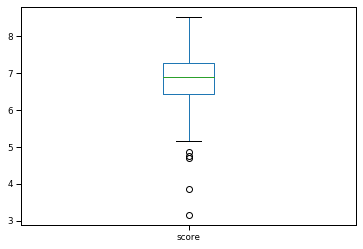

In [155]:
animeList[(animeList['studio'] == 'Toei Animation')].score.plot.box()

### Members Plot dos estúdios analisados

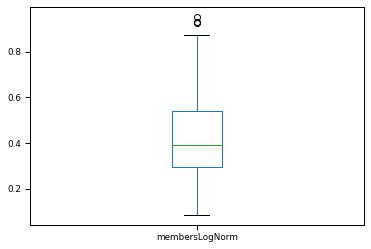

In [156]:
animeList[(animeList['studio'] == 'Sunrise')].membersLogNorm.plot.box()

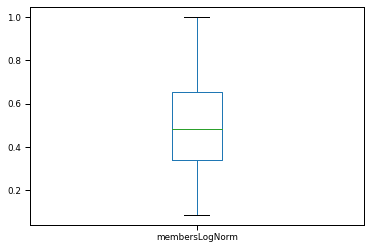

In [157]:
animeList[(animeList['studio'] == 'Madhouse')].membersLogNorm.plot.box()

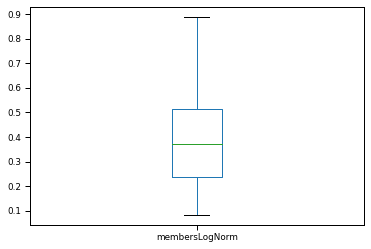

In [158]:
animeList[(animeList['studio'] == 'Toei Animation')].membersLogNorm.plot.box()

Temos então na comparação da **Sunrise** com a **Madhouse** que:
- Animes da 'Sunrise' geralmente possuem score ligeiramente maior
- O alcance dos animes da **Madhouse**,em sua maioria, são maiores, principalmente de Shounen, tendo em vista uma quantidade de membros maior.
- Os dados não são identicos por possuir p-value muito baixo

Como análise geral, temos que:
- Animes da **Madhouse** possuem tendência a possuir um alcance muito maior, principalmente para animes Shounen.
- Animes da **Sunrise** possui scores ligeiramente maiores em relação aos demais estúdios.
- Animes da **Toei Animation**, apesar de possuirem quantidade de membros menores, prossegue sendo boa escolha por não haver tanta diferença em seus scores.

**Toei Animation** é responsável pela produção de alguns animes longos famosos como One Piece, Cavaleiros do Zodiaco e Dragon Ball Z

# Clustering

Acima, dividimos os membros em 6 quantis, e também pelos gráficos conseguimos observar que os animes com mais membros tendem a ter um score maior. Agora, ao invés de separar pelos quantis, tentaremos achar clusters.

In [159]:
animeCluster = animeList[['score', 'members']]
# toCluster = np.asarray([np.asarray(c['score']), np.asarray(c['members'])]).T

Utilizaremos o silhouette score para selecionar qual o melhor número de clusters, variando de 2 a 6

In [160]:
X = animeCluster
for k in tqdm(range(2,7)):
    k_means = KMeans(n_clusters = k, random_state=2020)
    labels = k_means.fit_predict(X)
    silhouette_avg = silhouette_score(X, labels)
    print("For k clusters =", k,
          "The average silhouette_score is :", silhouette_avg)


 20%|██        | 1/5 [00:01<00:06,  1.67s/it]

For k clusters = 2 The average silhouette_score is : 0.9032165523873967


 40%|████      | 2/5 [00:03<00:05,  1.69s/it]

For k clusters = 3 The average silhouette_score is : 0.8537163718333605


 60%|██████    | 3/5 [00:05<00:03,  1.67s/it]

For k clusters = 4 The average silhouette_score is : 0.8178538404518062


 80%|████████  | 4/5 [00:06<00:01,  1.67s/it]

For k clusters = 5 The average silhouette_score is : 0.7906445117832257


100%|██████████| 5/5 [00:08<00:00,  1.68s/it]

For k clusters = 6 The average silhouette_score is : 0.775659037557132


k = 2 obteve o melhor score, porém utilizaremos k = 3 para ter uma divisão maior

In [161]:
k_means = KMeans(n_clusters=3, random_state=2020)

labels = k_means.fit_predict(animeCluster)
animeCluster['label'] = labels
animeCluster['label'] = animeCluster['label'].astype('category')

/Users/lionliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/lionliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


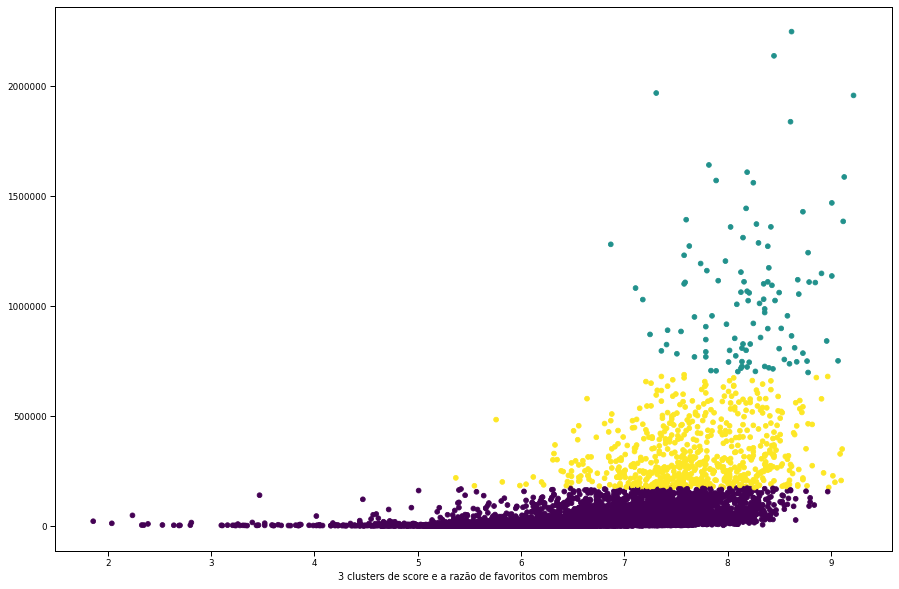

In [162]:
plt.figure(figsize=(15,10))
plt.scatter(animeCluster['score'], animeCluster['members'], c=labels)
plt.xlabel('3 clusters de score e a razão de favoritos com membros');

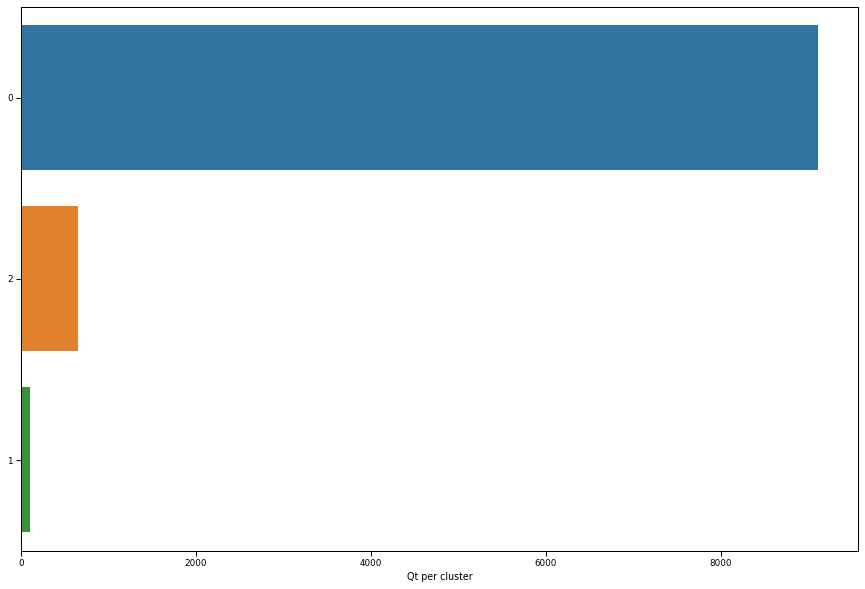

In [163]:
countCluster = animeCluster.label.value_counts()
plt.figure(figsize=(15,10))
sns.barplot(x=countCluster.values, y=countCluster.index,orient="h", order=countCluster.index)
plt.xlabel("Qt per cluster")
plt.show()

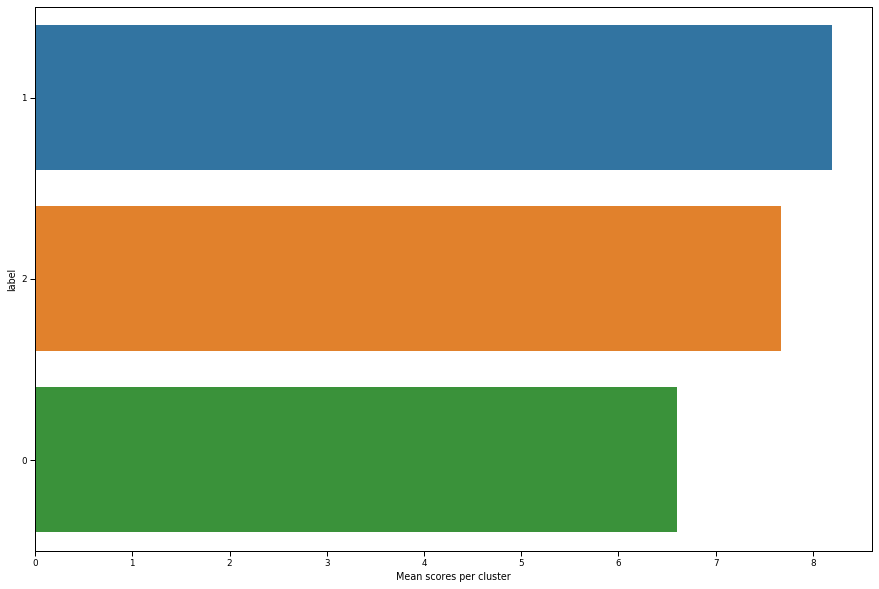

In [164]:
meanCluster = animeCluster.groupby("label").score.mean().sort_values(ascending=False)
plt.figure(figsize=(15,10))
sns.barplot(x=meanCluster.values, y=meanCluster.index,orient="h", order=meanCluster.index)
plt.xlabel("Mean scores per cluster")
plt.show()

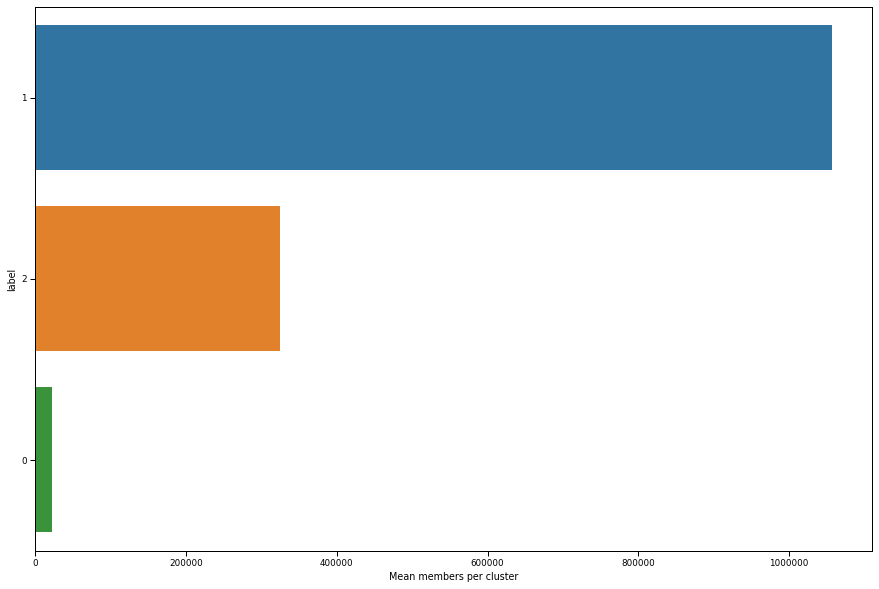

In [165]:
meanCluster = animeCluster.groupby("label").members.mean().sort_values(ascending=False)
plt.figure(figsize=(15,10))
sns.barplot(x=meanCluster.values, y=meanCluster.index,orient="h", order=meanCluster.index)
plt.xlabel("Mean members per cluster")
plt.show()

Com separacao do dataset com 3 clusters, foi dividido os animes com maior nota dos com menor nota, sendo também verdade para a média da quantidade de membros.